# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics
We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to recover the primitive pressure from the conserved variables.

Use this first cell to convert this notebook to a python script.



1.   List item
2.   List item



In [ ]:
%%script echo skipping

!jupyter nbconvert pt7.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on google colab,

In [ ]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


device(type='cuda')

## Constants and flags to set
Defining some constants and parameters for convenience.

In [ ]:

N_TRIALS = 300 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.

# I try out here the values as obtained in Optuna run 5, but I will increase the number of epochs.
# N_LAYERS_NO_OPT = 3
# N_UNITS_NO_OPT = [78, 193, 99]
# HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
# OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
# LOSS_NAME_NO_OPT = "MSE"
# OPTIMIZER_NAME_NO_OPT = "Adam"
# LR_NO_OPT = 0.00036516467819506355
# BATCH_SIZE_NO_OPT = 170
# N_EPOCHS_NO_OPT = 400
# SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

# Dieselhorst hyperparameters
N_LAYERS_NO_OPT = 2
N_UNITS_NO_OPT = [600, 200]
HIDDEN_ACTIVATION_NAME_NO_OPT = "Sigmoid"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "MSE"
OPTIMIZER_NAME_NO_OPT = "Adam"
LR_NO_OPT = 6e-3
BATCH_SIZE_NO_OPT = 32
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"


c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, 0.721 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(20) # Uncomment for pseudorandom data.

## Generating the data

In [ ]:

# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon


# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, epsilon


# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    W = 1 / torch.sqrt(1 - vx ** 2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, tau = compute_conserved_variables(rho, vx, epsilon)

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p

Sampling the primitive variables using the sample_primitive_variables function

In [ ]:
rho_train, vx_train, epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test, epsilon_test = sample_primitive_variables(n_test_samples)


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

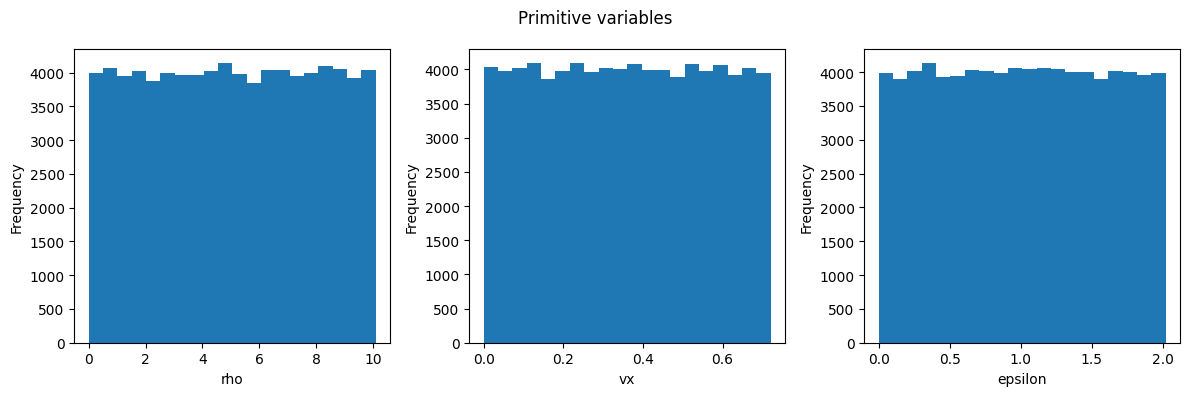

In [ ]:
# Plotting the histograms of rho, vx and epsilon
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(rho_train, bins=20)
plt.xlabel("rho")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(vx_train, bins=20)
plt.xlabel("vx")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(epsilon_train, bins=20)
plt.xlabel("epsilon")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.suptitle("Primitive variables")
plt.tight_layout()
plt.show()



In [ ]:

# Generating the input and output data for train and test sets.
x_train = generate_input_data(rho_train, vx_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, epsilon_test) 
y_test = generate_labels(rho_test, epsilon_test) 


tensor([ 0.4171,  1.6760,  2.8038,  ...,  2.8523,  0.9134, 10.3991],
       device='cuda:0')

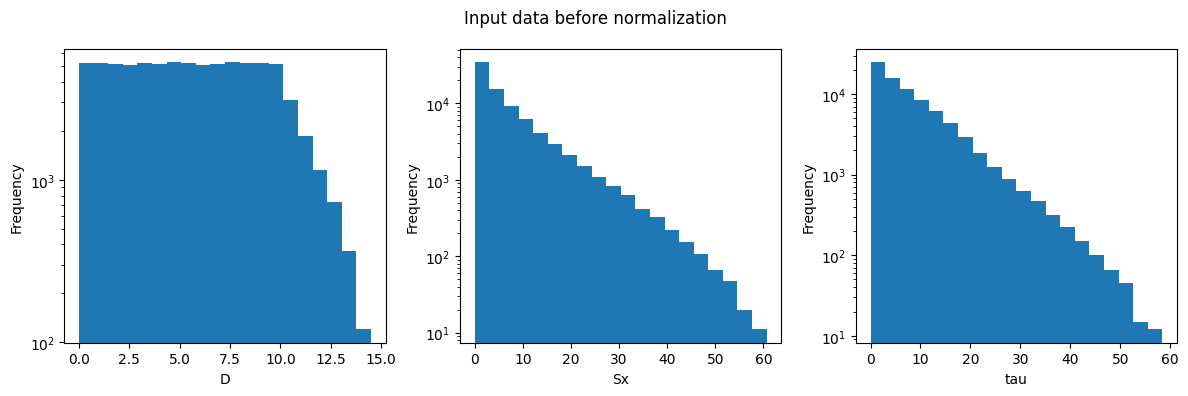

In [ ]:
# Plotting the histograms of the input data before normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data before normalization")
plt.tight_layout()
plt.show()


Perform z-score normalization

In [ ]:
if ZSCORE_NORMALIZATION:
    # Computing the mean and standard deviation of each input variable from the training set
    D_mean = torch.mean(x_train[:, 0])
    D_std = torch.std(x_train[:, 0])
    Sx_mean = torch.mean(x_train[:, 1])
    Sx_std = torch.std(x_train[:, 1])
    tau_mean = torch.mean(x_train[:, 2])
    tau_std = torch.std(x_train[:, 2])

    # Applying z-score normalization to both train and test sets using the statistics from the training set
    x_train[:, 0] = torch.sub(x_train[:, 0], D_mean).div(D_std)
    x_train[:, 1] = torch.sub(x_train[:, 1], Sx_mean).div(Sx_std)
    x_train[:, 2] = torch.sub(x_train[:, 2], tau_mean).div(tau_std)
    x_test[:, 0] = torch.sub(x_test[:, 0], D_mean).div(D_std)
    x_test[:, 1] = torch.sub(x_test[:, 1], Sx_mean).div(Sx_std)
    x_test[:, 2] = torch.sub(x_test[:, 2], tau_mean).div(tau_std)


tensor(5.6467, device='cuda:0')
tensor(3.3326, device='cuda:0')
tensor(6.8863, device='cuda:0')
tensor(8.1151, device='cuda:0')
tensor(8.0492, device='cuda:0')
tensor(7.8503, device='cuda:0')


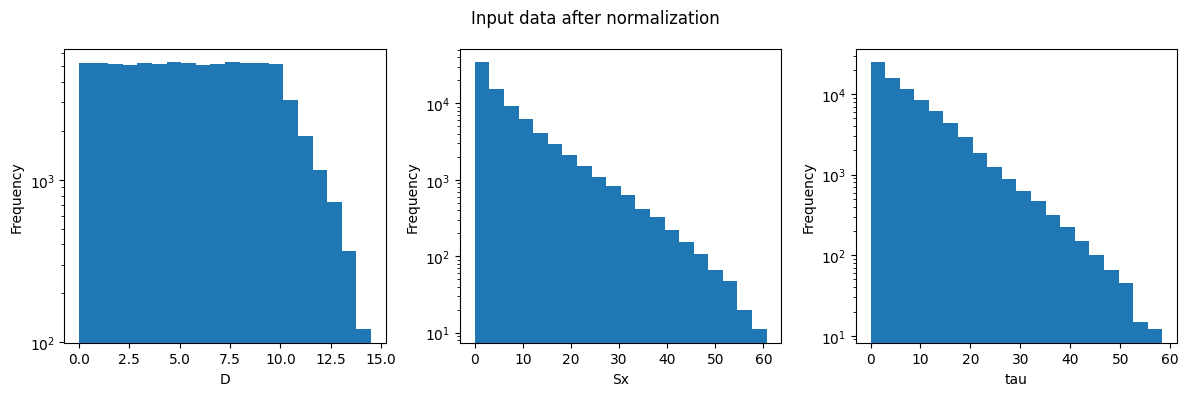

In [ ]:

# Verifying that the means and the stds of the input data are close to 0 and 1 respectively.
print(torch.mean(x_train[:, 0]))
print(torch.std(x_train[:, 0]))
print(torch.mean(x_train[:, 1]))
print(torch.std(x_train[:, 1]))
print(torch.mean(x_train[:, 2]))
print(torch.std(x_train[:, 2]))

# Plotting the histograms of the input data after normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data after normalization")
plt.tight_layout()
plt.show()


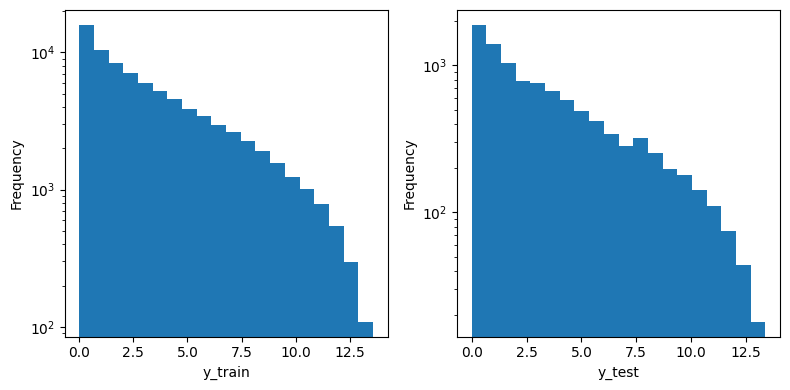

In [ ]:
# Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x

## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 1, 5)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 1048) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            "output_activation", ["ReLU", "Softplus"]
        ) 
        loss_name = trial.suggest_categorical(
            #"loss", ["MSE", "MAE", "Huber", "LogCosh"] 
            "loss", ["MSE", "MAE", "Huber"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
        batch_size = trial.suggest_int("batch_size", 16, 512)
        n_epochs = trial.suggest_int("n_epochs", 50, 200) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    if optimize:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            # Added sampling the weight decay and momentum for SGD
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            # Added sampling the weight decay and beta parameters for Adam
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
            beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            # Added sampling the step_size and gamma for StepLR
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.05, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            # Added sampling the gamma for ExponentialLR
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            # Added sampling the T_max for CosineAnnealingLR
            T_max = trial.suggest_int("T_max", 5, 15)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added sampling the factor, patience and threshold for ReduceLROnPlateau
            factor = trial.suggest_uniform("factor", 0.1, 0.9)
            patience = trial.suggest_int("patience", 5, 15)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        # # Added using OneCycleLR scheduler as an option
        # elif scheduler_name == "OneCycleLR":
        #         # Added sampling the max_lr and pct_start for OneCycleLR
        #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
        #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
        #         scheduler = optim.lr_scheduler.OneCycleLR(
        #             optimizer,
        #             max_lr=max_lr,
        #             epochs=n_epochs,
        #             steps_per_epoch=len(train_loader),
        #             pct_start=pct_start,
        #         )
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            # Added creating the CosineAnnealingLR scheduler
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added creating the ReduceLROnPlateau scheduler
            # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
            #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            #    optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
            #)
            # Use Dieseldorst et al. settings and add to that a minimum lr.
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.5, patience=5, threshold=0.0005, min_lr=1e-6
                    )
        else:
            scheduler = None


    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-14 19:56:56,624] A new study created in memory with name: no-name-c03a512a-d1b1-4968-8878-2714a2da16af
<ipython-input-26-6132826d8619>:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
<ipython-input-26-6132826d8619>:145: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.9)
<ipython-input-26-6132826d8619>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  threshold = trial.su

Epoch 1: Train Loss: 9.2366, Test Loss: 8.9301, Train L1 Norm: 31.4613, Test L1 Norm: 36.0886, Train Linf Norm: 6601.8697, Test Linf Norm: 7337.2771
Epoch 2: Train Loss: 8.7192, Test Loss: 8.7465, Train L1 Norm: 32.6532, Test L1 Norm: 35.2910, Train Linf Norm: 6736.6594, Test Linf Norm: 7173.5850
Epoch 3: Train Loss: 8.4804, Test Loss: 8.4382, Train L1 Norm: 31.7156, Test L1 Norm: 33.8194, Train Linf Norm: 6604.0229, Test Linf Norm: 6873.2951
Epoch 4: Train Loss: 8.0472, Test Loss: 7.8239, Train L1 Norm: 30.0055, Test L1 Norm: 31.1625, Train Linf Norm: 6261.7118, Test Linf Norm: 6333.1050
Epoch 5: Train Loss: 7.0803, Test Loss: 6.4003, Train L1 Norm: 26.4949, Test L1 Norm: 25.1245, Train Linf Norm: 5539.3829, Test Linf Norm: 5107.5508
Epoch 6: Train Loss: 5.2725, Test Loss: 4.3920, Train L1 Norm: 19.2771, Test L1 Norm: 15.6299, Train Linf Norm: 4044.7214, Test Linf Norm: 3183.9785
Epoch 7: Train Loss: 3.6211, Test Loss: 3.1828, Train L1 Norm: 11.8839, Test L1 Norm: 9.6270, Train Linf N

[I 2023-05-14 19:58:49,338] Trial 0 finished with value: 0.8851050606742501 and parameters: {'n_layers': 5, 'n_units_0': 515, 'n_units_1': 511, 'n_units_2': 539, 'n_units_3': 844, 'n_units_4': 191, 'hidden_activation': 'Sigmoid', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.00030405150858406034, 'batch_size': 274, 'n_epochs': 63, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.46011547810581754, 'patience': 9, 'threshold': 0.00015744295983659948}. Best is trial 0 with value: 0.8851050606742501.


Epoch 63: Train Loss: 0.2477, Test Loss: 0.2454, Train L1 Norm: 0.5121, Test L1 Norm: 0.8851, Train Linf Norm: 87.8662, Test Linf Norm: 186.6376


<ipython-input-26-6132826d8619>:114: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-26-6132826d8619>:115: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
<ipython-input-26-6132826d8619>:137: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.8, 0.99)


Epoch 1: Train Loss: 2.5895, Test Loss: 0.5987, Train L1 Norm: 1.9054, Test L1 Norm: 1.2944, Train Linf Norm: 483.2115, Test Linf Norm: 377.7030
Epoch 2: Train Loss: 0.4646, Test Loss: 0.3775, Train L1 Norm: 0.4303, Test L1 Norm: 0.7526, Train Linf Norm: 16.7072, Test Linf Norm: 168.1949
Epoch 3: Train Loss: 0.3050, Test Loss: 0.2365, Train L1 Norm: 0.3580, Test L1 Norm: 0.5469, Train Linf Norm: 9.4021, Test Linf Norm: 103.4357
Epoch 4: Train Loss: 0.1781, Test Loss: 0.1245, Train L1 Norm: 0.2903, Test L1 Norm: 0.2418, Train Linf Norm: 6.9084, Test Linf Norm: 4.4019
Epoch 5: Train Loss: 0.0933, Test Loss: 0.0685, Train L1 Norm: 0.2193, Test L1 Norm: 0.1963, Train Linf Norm: 3.8101, Test Linf Norm: 6.3866
Epoch 6: Train Loss: 0.0591, Test Loss: 0.1348, Train L1 Norm: 0.1878, Test L1 Norm: 0.3382, Train Linf Norm: 3.5831, Test Linf Norm: 50.2155
Epoch 7: Train Loss: 0.0483, Test Loss: 0.0485, Train L1 Norm: 0.1769, Test L1 Norm: 0.1680, Train Linf Norm: 3.1499, Test Linf Norm: 1.0051
Epo

[I 2023-05-14 20:01:00,619] Trial 1 finished with value: 0.20456612716093658 and parameters: {'n_layers': 5, 'n_units_0': 513, 'n_units_1': 680, 'n_units_2': 1043, 'n_units_3': 228, 'n_units_4': 915, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.0009205418591152611, 'batch_size': 427, 'n_epochs': 100, 'scheduler': 'ExponentialLR', 'weight_decay': 0.0003283097246611034, 'momentum': 0.6043797762940137, 'gamma': 0.8700363153970623}. Best is trial 1 with value: 0.20456612716093658.


Epoch 100: Train Loss: 0.0234, Test Loss: 0.0233, Train L1 Norm: 0.1478, Test L1 Norm: 0.2046, Train Linf Norm: 3.2505, Test Linf Norm: 29.0617
Epoch 1: Train Loss: 0.3931, Test Loss: 0.0076, Train L1 Norm: 1.6684, Test L1 Norm: 0.6642, Train Linf Norm: 417.5265, Test Linf Norm: 188.9006
Epoch 2: Train Loss: 0.0079, Test Loss: 0.0022, Train L1 Norm: 0.3529, Test L1 Norm: 0.4893, Train Linf Norm: 87.1009, Test Linf Norm: 146.0890
Epoch 3: Train Loss: 0.0037, Test Loss: 0.0009, Train L1 Norm: 0.2680, Test L1 Norm: 0.3811, Train Linf Norm: 72.2329, Test Linf Norm: 115.2086
Epoch 4: Train Loss: 0.0016, Test Loss: 0.0010, Train L1 Norm: 0.2264, Test L1 Norm: 0.3151, Train Linf Norm: 62.0974, Test Linf Norm: 95.4323
Epoch 5: Train Loss: 0.0008, Test Loss: 0.0007, Train L1 Norm: 0.1953, Test L1 Norm: 0.2958, Train Linf Norm: 54.2910, Test Linf Norm: 90.1716
Epoch 6: Train Loss: 0.0008, Test Loss: 0.0002, Train L1 Norm: 0.1807, Test L1 Norm: 0.2582, Train Linf Norm: 51.0210, Test Linf Norm: 79

[I 2023-05-14 20:03:28,846] Trial 2 finished with value: 0.09981527957879006 and parameters: {'n_layers': 4, 'n_units_0': 343, 'n_units_1': 443, 'n_units_2': 522, 'n_units_3': 149, 'hidden_activation': 'ReLU', 'output_activation': 'Softplus', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.007562633489921022, 'batch_size': 380, 'n_epochs': 110, 'scheduler': 'None'}. Best is trial 2 with value: 0.09981527957879006.


Epoch 110: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0614, Test L1 Norm: 0.0998, Train Linf Norm: 18.7703, Test Linf Norm: 32.2641


<ipython-input-26-6132826d8619>:133: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.05, 0.5)


Epoch 1: Train Loss: 0.1585, Test Loss: 0.0019, Train L1 Norm: 0.2230, Test L1 Norm: 0.0561, Train Linf Norm: 14.2969, Test Linf Norm: 5.0086
Epoch 2: Train Loss: 0.0027, Test Loss: 0.0005, Train L1 Norm: 0.0399, Test L1 Norm: 0.0385, Train Linf Norm: 2.0726, Test Linf Norm: 3.3755
Epoch 3: Train Loss: 0.0012, Test Loss: 0.0002, Train L1 Norm: 0.0280, Test L1 Norm: 0.0247, Train Linf Norm: 1.3883, Test Linf Norm: 1.9641
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0207, Test L1 Norm: 0.0200, Train Linf Norm: 1.1285, Test Linf Norm: 1.3415
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0006, Train L1 Norm: 0.0203, Test L1 Norm: 0.0206, Train Linf Norm: 1.3917, Test Linf Norm: 0.7548
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0171, Test L1 Norm: 0.0146, Train Linf Norm: 0.9770, Test Linf Norm: 0.6694
Epoch 7: Train Loss: 0.0002, Test Loss: 0.0009, Train L1 Norm: 0.0156, Test L1 Norm: 0.0399, Train Linf Norm: 0.8593, Test Linf Norm: 4.6104
Epoch 8: Tra

[I 2023-05-14 20:05:24,335] Trial 3 finished with value: 0.01049279649015516 and parameters: {'n_layers': 2, 'n_units_0': 361, 'n_units_1': 949, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00306039087014448, 'batch_size': 197, 'n_epochs': 70, 'scheduler': 'StepLR', 'step_size': 8, 'gamma': 0.458638200418161}. Best is trial 3 with value: 0.01049279649015516.


Epoch 70: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0105, Test L1 Norm: 0.0105, Train Linf Norm: 0.7459, Test Linf Norm: 0.5820


<ipython-input-26-6132826d8619>:119: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-26-6132826d8619>:120: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
<ipython-input-26-6132826d8619>:121: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)


Epoch 1: Train Loss: 0.4006, Test Loss: 0.0005, Train L1 Norm: 1.6987, Test L1 Norm: 0.3978, Train Linf Norm: 372.3193, Test Linf Norm: 106.9410
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.1460, Test L1 Norm: 0.0889, Train Linf Norm: 37.9629, Test Linf Norm: 23.9450
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.1020, Test L1 Norm: 0.1483, Train Linf Norm: 28.0554, Test Linf Norm: 40.9256
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0929, Test L1 Norm: 0.0847, Train Linf Norm: 25.5326, Test Linf Norm: 22.7431
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.1105, Test L1 Norm: 0.1520, Train Linf Norm: 31.7151, Test Linf Norm: 42.7539
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.1027, Test L1 Norm: 0.1272, Train Linf Norm: 29.2036, Test Linf Norm: 36.5848
Epoch 7: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.1142, Test L1 Norm: 0.1502, Train Linf Norm: 33.5723, Test Linf Norm: 42.25

[I 2023-05-14 20:09:10,307] Trial 4 finished with value: 0.09997088772421703 and parameters: {'n_layers': 5, 'n_units_0': 515, 'n_units_1': 200, 'n_units_2': 75, 'n_units_3': 32, 'n_units_4': 964, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.00012804080812297896, 'batch_size': 362, 'n_epochs': 163, 'scheduler': 'StepLR', 'weight_decay': 2.8362863052696628e-05, 'beta1': 0.8944268455515874, 'beta2': 0.9620988369862872, 'step_size': 9, 'gamma': 0.1672868925090537}. Best is trial 3 with value: 0.01049279649015516.


Epoch 163: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0992, Test L1 Norm: 0.1000, Train Linf Norm: 30.7868, Test Linf Norm: 29.0125


[I 2023-05-14 20:09:11,402] Trial 5 pruned. 


Epoch 1: Train Loss: 3.3993, Test Loss: 3.4169, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 20:09:12,575] Trial 6 pruned. 


Epoch 1: Train Loss: 0.4802, Test Loss: 0.5893, Train L1 Norm: 4.1017, Test L1 Norm: 3.3496, Train Linf Norm: 615.4501, Test Linf Norm: 504.7895
Epoch 1: Train Loss: 4.3505, Test Loss: 2.2540, Train L1 Norm: 1.9597, Test L1 Norm: 0.5357, Train Linf Norm: 130.2448, Test Linf Norm: 3.0000
Epoch 2: Train Loss: 1.6121, Test Loss: 1.1996, Train L1 Norm: 0.4537, Test L1 Norm: 0.4017, Train Linf Norm: 1.6476, Test Linf Norm: 1.4549


[I 2023-05-14 20:09:18,277] Trial 7 pruned. 


Epoch 3: Train Loss: 0.9420, Test Loss: 0.7904, Train L1 Norm: 0.4055, Test L1 Norm: 1.0610, Train Linf Norm: 7.0269, Test Linf Norm: 125.9813


[I 2023-05-14 20:09:19,637] Trial 8 pruned. 


Epoch 1: Train Loss: 3.3993, Test Loss: 3.4169, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 20:09:22,157] Trial 9 pruned. 


Epoch 1: Train Loss: 20.4833, Test Loss: 20.7406, Train L1 Norm: 1.0084, Test L1 Norm: 1.0000, Train Linf Norm: 1.2153, Test Linf Norm: 1.0000


[I 2023-05-14 20:09:30,406] Trial 10 pruned. 


Epoch 1: Train Loss: 3.0939, Test Loss: 2.9696, Train L1 Norm: 1.3852, Test L1 Norm: 1.0013, Train Linf Norm: 7.5427, Test Linf Norm: 1.0628


[I 2023-05-14 20:09:32,195] Trial 11 pruned. 


Epoch 1: Train Loss: 0.2359, Test Loss: 0.0014, Train L1 Norm: 1.2281, Test L1 Norm: 0.9970, Train Linf Norm: 229.0785, Test Linf Norm: 231.1588


[I 2023-05-14 20:09:33,525] Trial 12 pruned. 


Epoch 1: Train Loss: 0.1960, Test Loss: 0.0132, Train L1 Norm: 1.1129, Test L1 Norm: 0.8124, Train Linf Norm: 208.9902, Test Linf Norm: 192.7977


[I 2023-05-14 20:09:34,534] Trial 13 pruned. 


Epoch 1: Train Loss: 0.9186, Test Loss: 0.0945, Train L1 Norm: 1.9052, Test L1 Norm: 1.1505, Train Linf Norm: 575.4762, Test Linf Norm: 385.5363


[I 2023-05-14 20:09:35,790] Trial 14 pruned. 


Epoch 1: Train Loss: 0.7638, Test Loss: 0.0981, Train L1 Norm: 1.8294, Test L1 Norm: 1.0208, Train Linf Norm: 404.1935, Test Linf Norm: 270.2150


[I 2023-05-14 20:09:37,247] Trial 15 pruned. 


Epoch 1: Train Loss: 0.5750, Test Loss: 0.0281, Train L1 Norm: 4.2540, Test L1 Norm: 3.2726, Train Linf Norm: 746.9194, Test Linf Norm: 587.8921


[I 2023-05-14 20:09:39,331] Trial 16 pruned. 


Epoch 1: Train Loss: 2.9875, Test Loss: 2.9696, Train L1 Norm: 1.1006, Test L1 Norm: 1.0000, Train Linf Norm: 8.5846, Test Linf Norm: 1.0000


[I 2023-05-14 20:09:41,711] Trial 17 pruned. 


Epoch 1: Train Loss: 0.0417, Test Loss: 0.0008, Train L1 Norm: 1.4394, Test L1 Norm: 0.9282, Train Linf Norm: 136.5722, Test Linf Norm: 92.1381


[I 2023-05-14 20:09:44,160] Trial 18 pruned. 


Epoch 1: Train Loss: 2.9999, Test Loss: 2.9696, Train L1 Norm: 1.6297, Test L1 Norm: 1.1883, Train Linf Norm: 90.1078, Test Linf Norm: 27.9379
Epoch 1: Train Loss: 1.5726, Test Loss: 0.5298, Train L1 Norm: 2.8389, Test L1 Norm: 0.3550, Train Linf Norm: 475.5663, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 0.3494, Test Loss: 0.2621, Train L1 Norm: 0.2869, Test L1 Norm: 0.5092, Train Linf Norm: 13.9256, Test Linf Norm: 116.8076
Epoch 3: Train Loss: 0.2119, Test Loss: 0.1741, Train L1 Norm: 0.2109, Test L1 Norm: 0.2970, Train Linf Norm: 20.4069, Test Linf Norm: 59.8498
Epoch 4: Train Loss: 0.1559, Test Loss: 0.1375, Train L1 Norm: 0.1890, Test L1 Norm: 0.2332, Train Linf Norm: 22.1980, Test Linf Norm: 42.3124


[I 2023-05-14 20:09:49,991] Trial 19 pruned. 


Epoch 5: Train Loss: 0.1200, Test Loss: 0.1053, Train L1 Norm: 0.1654, Test L1 Norm: 0.2494, Train Linf Norm: 20.5394, Test Linf Norm: 58.9216


[I 2023-05-14 20:09:51,298] Trial 20 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1779, Test Loss: 0.0010, Train L1 Norm: 0.9773, Test L1 Norm: 0.1145, Train Linf Norm: 207.0401, Test Linf Norm: 30.5868
Epoch 2: Train Loss: 0.0014, Test Loss: 0.0003, Train L1 Norm: 0.1376, Test L1 Norm: 0.1948, Train Linf Norm: 36.5289, Test Linf Norm: 55.3108
Epoch 3: Train Loss: 0.0015, Test Loss: 0.0004, Train L1 Norm: 0.1168, Test L1 Norm: 0.2928, Train Linf Norm: 29.8425, Test Linf Norm: 83.4417
Epoch 4: Train Loss: 0.0010, Test Loss: 0.0007, Train L1 Norm: 0.1448, Test L1 Norm: 0.1499, Train Linf Norm: 40.6994, Test Linf Norm: 40.6094
Epoch 5: Train Loss: 0.0010, Test Loss: 0.0001, Train L1 Norm: 0.1191, Test L1 Norm: 0.0670, Train Linf Norm: 31.5748, Test Linf Norm: 15.6499
Epoch 6: Train Loss: 0.0008, Test Loss: 0.0001, Train L1 Norm: 0.1284, Test L1 Norm: 0.1116, Train Linf Norm: 35.8660, Test Linf Norm: 33.1746


[I 2023-05-14 20:13:17,801] Trial 21 finished with value: 0.09110442864149809 and parameters: {'n_layers': 5, 'n_units_0': 395, 'n_units_1': 140, 'n_units_2': 52, 'n_units_3': 37, 'n_units_4': 1037, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.0006429110564989245, 'batch_size': 365, 'n_epochs': 151, 'scheduler': 'StepLR', 'weight_decay': 1.6246449807970893e-05, 'beta1': 0.9019452264688282, 'beta2': 0.9585233142656489, 'step_size': 9, 'gamma': 0.14852882870885994}. Best is trial 3 with value: 0.01049279649015516.


Epoch 151: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0785, Test L1 Norm: 0.0911, Train Linf Norm: 23.6480, Test Linf Norm: 27.1868
Epoch 1: Train Loss: 1.6246, Test Loss: 0.0021, Train L1 Norm: 1.2877, Test L1 Norm: 0.5029, Train Linf Norm: 204.5290, Test Linf Norm: 151.5800
Epoch 2: Train Loss: 0.0076, Test Loss: 0.0133, Train L1 Norm: 0.2578, Test L1 Norm: 0.2639, Train Linf Norm: 77.3217, Test Linf Norm: 79.3494
Epoch 3: Train Loss: 0.0070, Test Loss: 0.0003, Train L1 Norm: 0.1905, Test L1 Norm: 0.2180, Train Linf Norm: 57.0647, Test Linf Norm: 70.7118
Epoch 4: Train Loss: 0.0063, Test Loss: 0.0032, Train L1 Norm: 0.1824, Test L1 Norm: 0.1609, Train Linf Norm: 54.1014, Test Linf Norm: 48.2380
Epoch 5: Train Loss: 0.0084, Test Loss: 0.0007, Train L1 Norm: 0.1872, Test L1 Norm: 0.1996, Train Linf Norm: 55.3824, Test Linf Norm: 65.2635
Epoch 6: Train Loss: 0.0065, Test Loss: 0.0007, Train L1 Norm: 0.1740, Test L1 Norm: 0.1582, Train Linf Norm: 51.4837, Test Linf Norm: 50.

[I 2023-05-14 20:13:28,504] Trial 22 pruned. 


Epoch 8: Train Loss: 0.0047, Test Loss: 0.0007, Train L1 Norm: 0.1704, Test L1 Norm: 0.1915, Train Linf Norm: 51.3749, Test Linf Norm: 63.3922


[I 2023-05-14 20:13:29,842] Trial 23 pruned. 


Epoch 1: Train Loss: 0.0969, Test Loss: 0.0168, Train L1 Norm: 1.6657, Test L1 Norm: 0.6908, Train Linf Norm: 448.3305, Test Linf Norm: 166.9800


[I 2023-05-14 20:13:31,102] Trial 24 pruned. 


Epoch 1: Train Loss: 0.1891, Test Loss: 0.0094, Train L1 Norm: 1.2623, Test L1 Norm: 0.5471, Train Linf Norm: 403.6461, Test Linf Norm: 192.3143


[I 2023-05-14 20:13:32,315] Trial 25 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 20:13:33,678] Trial 26 pruned. 


Epoch 1: Train Loss: 0.3025, Test Loss: 0.0227, Train L1 Norm: 2.3432, Test L1 Norm: 0.9643, Train Linf Norm: 806.6709, Test Linf Norm: 302.8269
Epoch 1: Train Loss: 0.2137, Test Loss: 0.0046, Train L1 Norm: 0.4216, Test L1 Norm: 0.4759, Train Linf Norm: 60.4707, Test Linf Norm: 113.6241


[I 2023-05-14 20:13:36,054] Trial 27 pruned. 


Epoch 2: Train Loss: 0.0227, Test Loss: 0.0166, Train L1 Norm: 0.2765, Test L1 Norm: 0.4162, Train Linf Norm: 53.5964, Test Linf Norm: 92.5293


[I 2023-05-14 20:13:37,267] Trial 28 pruned. 


Epoch 1: Train Loss: 6834.3043, Test Loss: 20.7406, Train L1 Norm: 5.2052, Test L1 Norm: 1.0000, Train Linf Norm: 164.3980, Test Linf Norm: 1.0000


[I 2023-05-14 20:13:39,113] Trial 29 pruned. 


Epoch 1: Train Loss: 1.6691, Test Loss: 0.7046, Train L1 Norm: 8.4612, Test L1 Norm: 0.9365, Train Linf Norm: 1325.8522, Test Linf Norm: 157.6471
Epoch 1: Train Loss: 0.6427, Test Loss: 0.0780, Train L1 Norm: 0.5582, Test L1 Norm: 0.2185, Train Linf Norm: 118.3998, Test Linf Norm: 42.1393
Epoch 2: Train Loss: 0.0061, Test Loss: 0.0011, Train L1 Norm: 0.2438, Test L1 Norm: 0.1918, Train Linf Norm: 69.0718, Test Linf Norm: 54.2149
Epoch 3: Train Loss: 0.0019, Test Loss: 0.0077, Train L1 Norm: 0.1586, Test L1 Norm: 0.1061, Train Linf Norm: 45.5337, Test Linf Norm: 24.1534
Epoch 4: Train Loss: 0.0008, Test Loss: 0.0004, Train L1 Norm: 0.0995, Test L1 Norm: 0.0953, Train Linf Norm: 27.2310, Test Linf Norm: 26.8212
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0682, Test L1 Norm: 0.0799, Train Linf Norm: 18.3905, Test Linf Norm: 22.2695
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0635, Test L1 Norm: 0.0763, Train Linf Norm: 17.3796, Test Linf Norm: 21.

[I 2023-05-14 20:17:17,235] Trial 30 finished with value: 0.019497579532675446 and parameters: {'n_layers': 5, 'n_units_0': 436, 'n_units_1': 608, 'n_units_2': 926, 'n_units_3': 164, 'n_units_4': 757, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.001438349508165813, 'batch_size': 390, 'n_epochs': 155, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 3 with value: 0.01049279649015516.


Epoch 155: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0096, Test L1 Norm: 0.0195, Train Linf Norm: 2.0825, Test Linf Norm: 5.3754


[I 2023-05-14 20:17:18,641] Trial 31 pruned. 


Epoch 1: Train Loss: 0.8448, Test Loss: 0.0161, Train L1 Norm: 0.8293, Test L1 Norm: 0.5490, Train Linf Norm: 208.5740, Test Linf Norm: 160.0551


[I 2023-05-14 20:17:19,857] Trial 32 pruned. 


Epoch 1: Train Loss: 0.5955, Test Loss: 0.0164, Train L1 Norm: 0.6174, Test L1 Norm: 0.4758, Train Linf Norm: 159.3301, Test Linf Norm: 162.9792


[I 2023-05-14 20:17:21,185] Trial 33 pruned. 


Epoch 1: Train Loss: 0.8148, Test Loss: 0.1082, Train L1 Norm: 0.9260, Test L1 Norm: 0.7812, Train Linf Norm: 244.5777, Test Linf Norm: 224.3753
Epoch 1: Train Loss: 1.5252, Test Loss: 0.3514, Train L1 Norm: 0.5976, Test L1 Norm: 0.3628, Train Linf Norm: 33.5824, Test Linf Norm: 25.2357


[I 2023-05-14 20:17:25,215] Trial 34 pruned. 


Epoch 2: Train Loss: 0.2319, Test Loss: 0.0989, Train L1 Norm: 0.2495, Test L1 Norm: 0.1997, Train Linf Norm: 3.5409, Test Linf Norm: 6.2198


[I 2023-05-14 20:17:26,421] Trial 35 pruned. 


Epoch 1: Train Loss: 1.8170, Test Loss: 0.0057, Train L1 Norm: 0.7849, Test L1 Norm: 0.6027, Train Linf Norm: 170.5577, Test Linf Norm: 179.7537


[I 2023-05-14 20:17:27,975] Trial 36 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 20:17:29,036] Trial 37 pruned. 


Epoch 1: Train Loss: 3.3993, Test Loss: 3.4169, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1981, Test Loss: 0.0125, Train L1 Norm: 1.0110, Test L1 Norm: 0.2741, Train Linf Norm: 139.1853, Test Linf Norm: 32.6481


[I 2023-05-14 20:17:32,631] Trial 38 pruned. 


Epoch 2: Train Loss: 0.0190, Test Loss: 0.0015, Train L1 Norm: 0.4994, Test L1 Norm: 0.5229, Train Linf Norm: 71.5873, Test Linf Norm: 77.3725


[I 2023-05-14 20:17:33,604] Trial 39 pruned. 


Epoch 1: Train Loss: 20.4814, Test Loss: 20.7406, Train L1 Norm: 1.0572, Test L1 Norm: 1.0000, Train Linf Norm: 10.2130, Test Linf Norm: 1.0000


[I 2023-05-14 20:17:35,716] Trial 40 pruned. 


Epoch 1: Train Loss: 3.3993, Test Loss: 3.4169, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 20:17:37,489] Trial 41 pruned. 


Epoch 1: Train Loss: 0.6202, Test Loss: 0.0049, Train L1 Norm: 2.0221, Test L1 Norm: 1.0820, Train Linf Norm: 487.2429, Test Linf Norm: 361.9042
Epoch 1: Train Loss: 0.2990, Test Loss: 0.0043, Train L1 Norm: 1.0618, Test L1 Norm: 0.1783, Train Linf Norm: 188.4313, Test Linf Norm: 42.9474
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0551, Test L1 Norm: 0.0466, Train Linf Norm: 9.7571, Test Linf Norm: 8.8767
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0766, Test L1 Norm: 0.0705, Train Linf Norm: 17.5518, Test Linf Norm: 16.9057
Epoch 4: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0582, Test L1 Norm: 0.1480, Train Linf Norm: 11.6411, Test Linf Norm: 36.6298
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0676, Test L1 Norm: 0.0538, Train Linf Norm: 15.0858, Test Linf Norm: 11.6692
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0824, Test L1 Norm: 0.1520, Train Linf Norm: 19.5151, Test Linf Norm: 37.250

[I 2023-05-14 20:21:31,606] Trial 42 finished with value: 0.07268544361731037 and parameters: {'n_layers': 5, 'n_units_0': 375, 'n_units_1': 218, 'n_units_2': 19, 'n_units_3': 91, 'n_units_4': 920, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.0001878506816593235, 'batch_size': 329, 'n_epochs': 163, 'scheduler': 'StepLR', 'weight_decay': 2.697924002054539e-05, 'beta1': 0.892482571128728, 'beta2': 0.9429782598674971, 'step_size': 8, 'gamma': 0.11363356304085376}. Best is trial 3 with value: 0.01049279649015516.


Epoch 163: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0674, Test L1 Norm: 0.0727, Train Linf Norm: 17.9994, Test Linf Norm: 18.3105


[I 2023-05-14 20:21:33,496] Trial 43 pruned. 


Epoch 1: Train Loss: 0.4461, Test Loss: 0.0157, Train L1 Norm: 2.9123, Test L1 Norm: 1.0425, Train Linf Norm: 634.2030, Test Linf Norm: 263.6556


[I 2023-05-14 20:21:35,463] Trial 44 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 20:21:37,192] Trial 45 pruned. 


Epoch 1: Train Loss: 2.9507, Test Loss: 2.9696, Train L1 Norm: 1.1362, Test L1 Norm: 0.9999, Train Linf Norm: 22.8101, Test Linf Norm: 1.0000


[I 2023-05-14 20:21:38,276] Trial 46 pruned. 


Epoch 1: Train Loss: 0.2741, Test Loss: 0.0105, Train L1 Norm: 5.3838, Test L1 Norm: 4.0709, Train Linf Norm: 1436.7916, Test Linf Norm: 1046.1484
Epoch 1: Train Loss: 0.1278, Test Loss: 0.0021, Train L1 Norm: 0.2986, Test L1 Norm: 0.2051, Train Linf Norm: 32.7116, Test Linf Norm: 41.5177
Epoch 2: Train Loss: 0.0013, Test Loss: 0.0005, Train L1 Norm: 0.0495, Test L1 Norm: 0.0774, Train Linf Norm: 6.3067, Test Linf Norm: 15.5943
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0268, Test L1 Norm: 0.0797, Train Linf Norm: 3.2376, Test Linf Norm: 17.1628
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0215, Test L1 Norm: 0.0581, Train Linf Norm: 2.7318, Test Linf Norm: 12.0660
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0183, Test L1 Norm: 0.0527, Train Linf Norm: 2.1620, Test Linf Norm: 10.9402
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0170, Test L1 Norm: 0.0516, Train Linf Norm: 2.0039, Test Linf Norm: 10.7552


[I 2023-05-14 20:25:14,904] Trial 47 finished with value: 0.006836824197042734 and parameters: {'n_layers': 4, 'n_units_0': 223, 'n_units_1': 1043, 'n_units_2': 128, 'n_units_3': 235, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0033857619617798417, 'batch_size': 254, 'n_epochs': 134, 'scheduler': 'CosineAnnealingLR', 'T_max': 7}. Best is trial 47 with value: 0.006836824197042734.


Epoch 134: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0057, Test L1 Norm: 0.0068, Train Linf Norm: 0.6540, Test Linf Norm: 0.8912
Epoch 1: Train Loss: 0.0830, Test Loss: 0.0014, Train L1 Norm: 0.3027, Test L1 Norm: 0.2006, Train Linf Norm: 37.9490, Test Linf Norm: 40.2946
Epoch 2: Train Loss: 0.0018, Test Loss: 0.0009, Train L1 Norm: 0.0845, Test L1 Norm: 0.1324, Train Linf Norm: 12.4205, Test Linf Norm: 25.7668
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0598, Test L1 Norm: 0.1221, Train Linf Norm: 9.3152, Test Linf Norm: 25.0587
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0447, Test L1 Norm: 0.0987, Train Linf Norm: 6.9097, Test Linf Norm: 20.1049


[I 2023-05-14 20:25:25,331] Trial 48 pruned. 


Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0365, Test L1 Norm: 0.0919, Train Linf Norm: 5.3420, Test Linf Norm: 18.6441


[I 2023-05-14 20:25:27,140] Trial 49 pruned. 


Epoch 1: Train Loss: 0.0344, Test Loss: 0.0189, Train L1 Norm: 0.4524, Test L1 Norm: 0.2575, Train Linf Norm: 56.4594, Test Linf Norm: 30.1384
Epoch 1: Train Loss: 0.0891, Test Loss: 0.0008, Train L1 Norm: 0.7398, Test L1 Norm: 0.2127, Train Linf Norm: 126.4369, Test Linf Norm: 35.9529
Epoch 2: Train Loss: 0.0009, Test Loss: 0.0003, Train L1 Norm: 0.1634, Test L1 Norm: 0.1572, Train Linf Norm: 27.8179, Test Linf Norm: 27.2857
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.1284, Test L1 Norm: 0.1207, Train Linf Norm: 22.8078, Test Linf Norm: 20.8635
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.1120, Test L1 Norm: 0.1010, Train Linf Norm: 20.0409, Test Linf Norm: 17.2549


[I 2023-05-14 20:25:36,964] Trial 50 pruned. 


Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.1088, Test L1 Norm: 0.1076, Train Linf Norm: 19.6817, Test Linf Norm: 18.6385


[I 2023-05-14 20:25:38,199] Trial 51 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 20:25:39,558] Trial 52 pruned. 


Epoch 1: Train Loss: 0.1521, Test Loss: 0.0022, Train L1 Norm: 1.4847, Test L1 Norm: 0.7376, Train Linf Norm: 323.0371, Test Linf Norm: 158.6640


[I 2023-05-14 20:25:40,961] Trial 53 pruned. 


Epoch 1: Train Loss: 0.1757, Test Loss: 0.0026, Train L1 Norm: 0.7969, Test L1 Norm: 0.4102, Train Linf Norm: 189.8976, Test Linf Norm: 116.9876


[I 2023-05-14 20:25:42,328] Trial 54 pruned. 


Epoch 1: Train Loss: 0.2013, Test Loss: 0.0033, Train L1 Norm: 1.6455, Test L1 Norm: 0.6473, Train Linf Norm: 415.2405, Test Linf Norm: 167.8849


[I 2023-05-14 20:25:48,172] Trial 55 pruned. 


Epoch 1: Train Loss: 0.0569, Test Loss: 0.0064, Train L1 Norm: 0.5212, Test L1 Norm: 1.2708, Train Linf Norm: 14.2504, Test Linf Norm: 43.4855


[I 2023-05-14 20:25:50,203] Trial 56 pruned. 


Epoch 1: Train Loss: 0.7301, Test Loss: 0.5511, Train L1 Norm: 0.4471, Test L1 Norm: 0.7340, Train Linf Norm: 18.3331, Test Linf Norm: 118.8592


[I 2023-05-14 20:25:52,095] Trial 57 pruned. 


Epoch 1: Train Loss: 22.0061, Test Loss: 2.9696, Train L1 Norm: 19.2200, Test L1 Norm: 1.0000, Train Linf Norm: 1464.0138, Test Linf Norm: 1.0000


[I 2023-05-14 20:25:53,202] Trial 58 pruned. 


Epoch 1: Train Loss: 0.3935, Test Loss: 0.0323, Train L1 Norm: 1.6640, Test L1 Norm: 0.6168, Train Linf Norm: 510.6109, Test Linf Norm: 155.7744


[I 2023-05-14 20:25:54,791] Trial 59 pruned. 


Epoch 1: Train Loss: 0.1807, Test Loss: 0.0426, Train L1 Norm: 0.6380, Test L1 Norm: 0.2586, Train Linf Norm: 106.5103, Test Linf Norm: 43.6247


[I 2023-05-14 20:25:56,000] Trial 60 pruned. 


Epoch 1: Train Loss: 0.4723, Test Loss: 0.1367, Train L1 Norm: 7.6742, Test L1 Norm: 7.5299, Train Linf Norm: 1824.1310, Test Linf Norm: 1770.7433


[I 2023-05-14 20:25:57,804] Trial 61 pruned. 


Epoch 1: Train Loss: 0.4408, Test Loss: 0.0005, Train L1 Norm: 1.3607, Test L1 Norm: 0.2754, Train Linf Norm: 269.9171, Test Linf Norm: 73.8144


[I 2023-05-14 20:25:59,913] Trial 62 pruned. 


Epoch 1: Train Loss: 0.9040, Test Loss: 0.0034, Train L1 Norm: 1.9988, Test L1 Norm: 1.0931, Train Linf Norm: 372.0879, Test Linf Norm: 294.1020
Epoch 1: Train Loss: 0.2889, Test Loss: 0.0021, Train L1 Norm: 1.7199, Test L1 Norm: 0.1881, Train Linf Norm: 486.0192, Test Linf Norm: 56.3090
Epoch 2: Train Loss: 0.0009, Test Loss: 0.0009, Train L1 Norm: 0.0859, Test L1 Norm: 0.1334, Train Linf Norm: 21.9964, Test Linf Norm: 41.8605
Epoch 3: Train Loss: 0.0008, Test Loss: 0.0002, Train L1 Norm: 0.0889, Test L1 Norm: 0.0939, Train Linf Norm: 24.9661, Test Linf Norm: 30.1425
Epoch 4: Train Loss: 0.0008, Test Loss: 0.0002, Train L1 Norm: 0.0708, Test L1 Norm: 0.1288, Train Linf Norm: 17.7902, Test Linf Norm: 41.5217


[I 2023-05-14 20:26:06,142] Trial 63 pruned. 


Epoch 5: Train Loss: 0.0007, Test Loss: 0.0004, Train L1 Norm: 0.0761, Test L1 Norm: 0.1192, Train Linf Norm: 19.9645, Test Linf Norm: 36.3315


[I 2023-05-14 20:26:07,551] Trial 64 pruned. 


Epoch 1: Train Loss: 0.0632, Test Loss: 0.0053, Train L1 Norm: 0.4188, Test L1 Norm: 0.3003, Train Linf Norm: 78.9734, Test Linf Norm: 63.1925


[I 2023-05-14 20:26:08,978] Trial 65 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 1.0619, Test Loss: 0.0089, Train L1 Norm: 0.5517, Test L1 Norm: 0.1224, Train Linf Norm: 160.7955, Test Linf Norm: 33.1237
Epoch 2: Train Loss: 0.0061, Test Loss: 0.0030, Train L1 Norm: 0.0494, Test L1 Norm: 0.0433, Train Linf Norm: 4.8765, Test Linf Norm: 4.7341
Epoch 3: Train Loss: 0.0028, Test Loss: 0.0014, Train L1 Norm: 0.0402, Test L1 Norm: 0.0550, Train Linf Norm: 3.9038, Test Linf Norm: 11.1329
Epoch 4: Train Loss: 0.0010, Test Loss: 0.0004, Train L1 Norm: 0.0323, Test L1 Norm: 0.0375, Train Linf Norm: 3.2892, Test Linf Norm: 6.4671
Epoch 5: Train Loss: 0.0006, Test Loss: 0.0004, Train L1 Norm: 0.0289, Test L1 Norm: 0.0297, Train Linf Norm: 3.0190, Test Linf Norm: 4.5947
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0317, Test L1 Norm: 0.0297, Train Linf Norm: 5.2400, Test Linf Norm: 4.9226
Epoch 7: 

[I 2023-05-14 20:29:30,662] Trial 66 finished with value: 0.016334685812238604 and parameters: {'n_layers': 2, 'n_units_0': 576, 'n_units_1': 1007, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0012597071209892907, 'batch_size': 415, 'n_epochs': 166, 'scheduler': 'StepLR', 'step_size': 11, 'gamma': 0.1880924577371652}. Best is trial 47 with value: 0.006836824197042734.


Epoch 166: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0158, Test L1 Norm: 0.0163, Train Linf Norm: 1.6483, Test Linf Norm: 1.6060
Epoch 1: Train Loss: 2.1816, Test Loss: 0.0053, Train L1 Norm: 0.2730, Test L1 Norm: 0.1582, Train Linf Norm: 27.2989, Test Linf Norm: 47.2465
Epoch 2: Train Loss: 0.0033, Test Loss: 0.0012, Train L1 Norm: 0.0463, Test L1 Norm: 0.0842, Train Linf Norm: 3.1217, Test Linf Norm: 22.6116
Epoch 3: Train Loss: 0.0012, Test Loss: 0.0008, Train L1 Norm: 0.0333, Test L1 Norm: 0.0481, Train Linf Norm: 2.6588, Test Linf Norm: 9.2980
Epoch 4: Train Loss: 0.0009, Test Loss: 0.0007, Train L1 Norm: 0.0289, Test L1 Norm: 0.0357, Train Linf Norm: 2.5103, Test Linf Norm: 5.3527
Epoch 5: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0244, Test L1 Norm: 0.0340, Train Linf Norm: 2.4578, Test Linf Norm: 6.2576
Epoch 6: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0232, Test L1 Norm: 0.0356, Train Linf Norm: 2.6414, Test Linf Norm: 7.7691
Epoch 7:

[I 2023-05-14 20:32:18,282] Trial 67 finished with value: 0.03769216002672911 and parameters: {'n_layers': 2, 'n_units_0': 761, 'n_units_1': 1004, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0017213557805340807, 'batch_size': 419, 'n_epochs': 139, 'scheduler': 'StepLR', 'step_size': 12, 'gamma': 0.1913407929922557}. Best is trial 47 with value: 0.006836824197042734.


Epoch 139: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0139, Test L1 Norm: 0.0377, Train Linf Norm: 1.7037, Test Linf Norm: 11.3630
Epoch 1: Train Loss: 1.8329, Test Loss: 0.0039, Train L1 Norm: 0.2039, Test L1 Norm: 0.0665, Train Linf Norm: 12.4458, Test Linf Norm: 7.6904
Epoch 2: Train Loss: 0.0046, Test Loss: 0.0070, Train L1 Norm: 0.0494, Test L1 Norm: 0.0588, Train Linf Norm: 5.2526, Test Linf Norm: 5.8837
Epoch 3: Train Loss: 0.0012, Test Loss: 0.0004, Train L1 Norm: 0.0364, Test L1 Norm: 0.0311, Train Linf Norm: 4.4954, Test Linf Norm: 3.9632
Epoch 4: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0309, Test L1 Norm: 0.0260, Train Linf Norm: 4.1608, Test Linf Norm: 1.6512
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0007, Train L1 Norm: 0.0235, Test L1 Norm: 0.0218, Train Linf Norm: 2.6182, Test Linf Norm: 1.7461
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0229, Test L1 Norm: 0.0185, Train Linf Norm: 2.8299, Test Linf Norm: 1.4506
Epoch 7: 

[I 2023-05-14 20:35:06,630] Trial 68 finished with value: 0.011394727131351829 and parameters: {'n_layers': 2, 'n_units_0': 819, 'n_units_1': 985, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0013530182592437381, 'batch_size': 437, 'n_epochs': 140, 'scheduler': 'StepLR', 'step_size': 13, 'gamma': 0.18839358069744774}. Best is trial 47 with value: 0.006836824197042734.


Epoch 140: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0132, Test L1 Norm: 0.0114, Train Linf Norm: 1.8055, Test Linf Norm: 0.9189


[I 2023-05-14 20:35:07,827] Trial 69 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 20:35:08,926] Trial 70 pruned. 


Epoch 1: Train Loss: 1.7561, Test Loss: 0.6576, Train L1 Norm: 1.2192, Test L1 Norm: 0.3819, Train Linf Norm: 190.1986, Test Linf Norm: 1.0000


[I 2023-05-14 20:35:10,852] Trial 71 pruned. 


Epoch 1: Train Loss: 20.6310, Test Loss: 20.7406, Train L1 Norm: 1.0470, Test L1 Norm: 1.0000, Train Linf Norm: 4.4983, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 2.3759, Test Loss: 0.0071, Train L1 Norm: 0.3218, Test L1 Norm: 0.1147, Train Linf Norm: 18.5860, Test Linf Norm: 25.0425
Epoch 2: Train Loss: 0.0122, Test Loss: 0.0015, Train L1 Norm: 0.0669, Test L1 Norm: 0.0657, Train Linf Norm: 4.0832, Test Linf Norm: 11.5568
Epoch 3: Train Loss: 0.0042, Test Loss: 0.0012, Train L1 Norm: 0.0429, Test L1 Norm: 0.0361, Train Linf Norm: 2.1383, Test Linf Norm: 2.4925
Epoch 4: Train Loss: 0.0034, Test Loss: 0.0005, Train L1 Norm: 0.0548, Test L1 Norm: 0.0365, Train Linf Norm: 9.8958, Test Linf Norm: 5.9081
Epoch 5: Train Loss: 0.0011, Test Loss: 0.0003, Train L1 Norm: 0.0277, Test L1 Norm: 0.0247, Train Linf Norm: 2.0609, Test Linf Norm: 2.0142
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0221, Test L1 Norm: 0.0268, Train Linf Norm: 2.3014, Test Linf Norm: 4.4740
Epoch 7:

[I 2023-05-14 20:38:04,382] Trial 72 finished with value: 0.018006005844101308 and parameters: {'n_layers': 2, 'n_units_0': 925, 'n_units_1': 1016, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0009287776494951007, 'batch_size': 412, 'n_epochs': 141, 'scheduler': 'StepLR', 'step_size': 12, 'gamma': 0.204617833356681}. Best is trial 47 with value: 0.006836824197042734.


Epoch 141: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0122, Test L1 Norm: 0.0180, Train Linf Norm: 1.3105, Test Linf Norm: 2.9151


[I 2023-05-14 20:38:05,489] Trial 73 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 1.2970, Test Loss: 0.0029, Train L1 Norm: 0.2333, Test L1 Norm: 0.1096, Train Linf Norm: 28.1350, Test Linf Norm: 35.1962


[I 2023-05-14 20:38:07,735] Trial 74 pruned. 


Epoch 2: Train Loss: 0.0019, Test Loss: 0.0008, Train L1 Norm: 0.0446, Test L1 Norm: 0.0984, Train Linf Norm: 7.4063, Test Linf Norm: 33.6750


[I 2023-05-14 20:38:08,785] Trial 75 pruned. 


Epoch 1: Train Loss: 1.4706, Test Loss: 0.5566, Train L1 Norm: 0.5680, Test L1 Norm: 0.8832, Train Linf Norm: 29.5107, Test Linf Norm: 235.0911
Epoch 1: Train Loss: 0.3737, Test Loss: 0.0284, Train L1 Norm: 0.4595, Test L1 Norm: 0.1413, Train Linf Norm: 83.4783, Test Linf Norm: 13.8986


[I 2023-05-14 20:38:10,866] Trial 76 pruned. 


Epoch 2: Train Loss: 0.0135, Test Loss: 0.0064, Train L1 Norm: 0.2738, Test L1 Norm: 0.1723, Train Linf Norm: 72.7868, Test Linf Norm: 32.9957
Epoch 1: Train Loss: 1.4251, Test Loss: 0.0104, Train L1 Norm: 0.5555, Test L1 Norm: 0.0564, Train Linf Norm: 146.2004, Test Linf Norm: 1.2069
Epoch 2: Train Loss: 0.0027, Test Loss: 0.0010, Train L1 Norm: 0.0371, Test L1 Norm: 0.0938, Train Linf Norm: 3.1056, Test Linf Norm: 31.7742
Epoch 3: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0267, Test L1 Norm: 0.0507, Train Linf Norm: 2.7974, Test Linf Norm: 13.2620
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0217, Test L1 Norm: 0.0362, Train Linf Norm: 2.0239, Test Linf Norm: 8.2871
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0194, Test L1 Norm: 0.0380, Train Linf Norm: 1.7114, Test Linf Norm: 10.0675
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0184, Test L1 Norm: 0.0326, Train Linf Norm: 1.5636, Test Linf Norm: 7.5188
Epoch 

[I 2023-05-14 20:40:53,654] Trial 77 finished with value: 0.009450663567800074 and parameters: {'n_layers': 2, 'n_units_0': 863, 'n_units_1': 835, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0011274866888018827, 'batch_size': 451, 'n_epochs': 137, 'scheduler': 'CosineAnnealingLR', 'T_max': 7}. Best is trial 47 with value: 0.006836824197042734.


Epoch 137: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0085, Test L1 Norm: 0.0095, Train Linf Norm: 1.0897, Test Linf Norm: 1.2122
Epoch 1: Train Loss: 8.5468, Test Loss: 0.0246, Train L1 Norm: 0.7907, Test L1 Norm: 0.1310, Train Linf Norm: 111.4225, Test Linf Norm: 32.0794


[I 2023-05-14 20:40:55,835] Trial 78 pruned. 


Epoch 2: Train Loss: 0.0153, Test Loss: 0.0079, Train L1 Norm: 0.0697, Test L1 Norm: 0.0871, Train Linf Norm: 6.5373, Test Linf Norm: 18.6366


[I 2023-05-14 20:40:56,939] Trial 79 pruned. 


Epoch 1: Train Loss: 2.6920, Test Loss: 0.0157, Train L1 Norm: 0.7096, Test L1 Norm: 0.3300, Train Linf Norm: 134.2741, Test Linf Norm: 80.9336


[I 2023-05-14 20:40:58,049] Trial 80 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.8076, Test Loss: 0.0056, Train L1 Norm: 0.1939, Test L1 Norm: 0.0760, Train Linf Norm: 15.4466, Test Linf Norm: 17.0529
Epoch 2: Train Loss: 0.0041, Test Loss: 0.0021, Train L1 Norm: 0.0363, Test L1 Norm: 0.0556, Train Linf Norm: 2.8289, Test Linf Norm: 10.9004
Epoch 3: Train Loss: 0.0010, Test Loss: 0.0018, Train L1 Norm: 0.0270, Test L1 Norm: 0.0295, Train Linf Norm: 2.5676, Test Linf Norm: 1.5702
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0230, Test L1 Norm: 0.0241, Train Linf Norm: 2.2256, Test Linf Norm: 2.4552
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0006, Train L1 Norm: 0.0209, Test L1 Norm: 0.0239, Train Linf Norm: 1.9838, Test Linf Norm: 1.5389
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0198, Test L1 Norm: 0.0215, Train Linf Norm: 1.9650, Test Linf Norm: 1.9994
Epoch 7:

[I 2023-05-14 20:44:11,064] Trial 81 finished with value: 0.007403118821047247 and parameters: {'n_layers': 2, 'n_units_0': 864, 'n_units_1': 1046, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0008717937060966688, 'batch_size': 396, 'n_epochs': 154, 'scheduler': 'CosineAnnealingLR', 'T_max': 10}. Best is trial 47 with value: 0.006836824197042734.


Epoch 154: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0071, Test L1 Norm: 0.0074, Train Linf Norm: 0.8934, Test Linf Norm: 0.7518
Epoch 1: Train Loss: 0.9340, Test Loss: 0.0065, Train L1 Norm: 0.2126, Test L1 Norm: 0.0575, Train Linf Norm: 19.0829, Test Linf Norm: 7.8718
Epoch 2: Train Loss: 0.0024, Test Loss: 0.0013, Train L1 Norm: 0.0336, Test L1 Norm: 0.0640, Train Linf Norm: 3.3476, Test Linf Norm: 18.8318
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0205, Test L1 Norm: 0.0328, Train Linf Norm: 2.0094, Test Linf Norm: 7.7639
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0174, Test L1 Norm: 0.0246, Train Linf Norm: 1.9683, Test Linf Norm: 5.3137
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0153, Test L1 Norm: 0.0209, Train Linf Norm: 1.5686, Test Linf Norm: 3.7774
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0141, Test L1 Norm: 0.0187, Train Linf Norm: 1.3432, Test Linf Norm: 2.9202
Epoch 7: 

[I 2023-05-14 20:47:12,102] Trial 82 finished with value: 0.00776743267858401 and parameters: {'n_layers': 2, 'n_units_0': 854, 'n_units_1': 960, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.000846902589315122, 'batch_size': 491, 'n_epochs': 158, 'scheduler': 'CosineAnnealingLR', 'T_max': 11}. Best is trial 47 with value: 0.006836824197042734.


Epoch 158: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0062, Test L1 Norm: 0.0078, Train Linf Norm: 0.8340, Test Linf Norm: 1.3330


[I 2023-05-14 20:47:13,206] Trial 83 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.9747, Test Loss: 0.0043, Train L1 Norm: 0.2340, Test L1 Norm: 0.0725, Train Linf Norm: 22.0032, Test Linf Norm: 16.8142
Epoch 2: Train Loss: 0.0026, Test Loss: 0.0094, Train L1 Norm: 0.0321, Test L1 Norm: 0.1044, Train Linf Norm: 1.9725, Test Linf Norm: 27.4878
Epoch 3: Train Loss: 0.0009, Test Loss: 0.0004, Train L1 Norm: 0.0236, Test L1 Norm: 0.0217, Train Linf Norm: 1.2330, Test Linf Norm: 1.3601
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0194, Test L1 Norm: 0.0194, Train Linf Norm: 1.1390, Test Linf Norm: 1.1127
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0177, Test L1 Norm: 0.0191, Train Linf Norm: 1.2214, Test Linf Norm: 1.4383
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0168, Test L1 Norm: 0.0229, Train Linf Norm: 1.2935, Test Linf Norm: 4.0354
Epoch 7:

[I 2023-05-14 20:50:15,585] Trial 84 finished with value: 0.007540425749029964 and parameters: {'n_layers': 2, 'n_units_0': 976, 'n_units_1': 864, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.000857536844911447, 'batch_size': 450, 'n_epochs': 153, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 47 with value: 0.006836824197042734.


Epoch 153: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0073, Test L1 Norm: 0.0075, Train Linf Norm: 0.9852, Test Linf Norm: 0.9129
Epoch 1: Train Loss: 1.1997, Test Loss: 0.0883, Train L1 Norm: 0.3030, Test L1 Norm: 0.1209, Train Linf Norm: 48.6121, Test Linf Norm: 1.4813
Epoch 2: Train Loss: 0.0090, Test Loss: 0.0021, Train L1 Norm: 0.0490, Test L1 Norm: 0.0479, Train Linf Norm: 5.4622, Test Linf Norm: 9.2283
Epoch 3: Train Loss: 0.0015, Test Loss: 0.0007, Train L1 Norm: 0.0293, Test L1 Norm: 0.0365, Train Linf Norm: 3.1808, Test Linf Norm: 7.2217
Epoch 4: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.0242, Test L1 Norm: 0.0339, Train Linf Norm: 2.8253, Test Linf Norm: 7.7759
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0215, Test L1 Norm: 0.0265, Train Linf Norm: 2.3933, Test Linf Norm: 4.6423
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0204, Test L1 Norm: 0.0206, Train Linf Norm: 2.5735, Test Linf Norm: 2.0638
Epoch 7: T

[I 2023-05-14 20:53:02,565] Trial 85 finished with value: 0.01010652033239603 and parameters: {'n_layers': 2, 'n_units_0': 997, 'n_units_1': 867, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0008541434261027383, 'batch_size': 495, 'n_epochs': 145, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 47 with value: 0.006836824197042734.


Epoch 145: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0076, Test L1 Norm: 0.0101, Train Linf Norm: 1.0701, Test Linf Norm: 2.0005


[I 2023-05-14 20:53:03,977] Trial 86 pruned. 


Epoch 1: Train Loss: 0.8079, Test Loss: 0.0198, Train L1 Norm: 0.3150, Test L1 Norm: 0.3229, Train Linf Norm: 55.1293, Test Linf Norm: 116.2895


[I 2023-05-14 20:53:05,571] Trial 87 pruned. 


Epoch 1: Train Loss: 0.8019, Test Loss: 0.1557, Train L1 Norm: 0.5176, Test L1 Norm: 0.1565, Train Linf Norm: 62.1136, Test Linf Norm: 1.6551
Epoch 1: Train Loss: 0.6070, Test Loss: 0.0092, Train L1 Norm: 0.2108, Test L1 Norm: 0.0730, Train Linf Norm: 27.8557, Test Linf Norm: 16.9286
Epoch 2: Train Loss: 0.0055, Test Loss: 0.0021, Train L1 Norm: 0.0395, Test L1 Norm: 0.0356, Train Linf Norm: 3.8772, Test Linf Norm: 5.0298
Epoch 3: Train Loss: 0.0014, Test Loss: 0.0008, Train L1 Norm: 0.0282, Test L1 Norm: 0.0354, Train Linf Norm: 2.9319, Test Linf Norm: 7.3629
Epoch 4: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.0238, Test L1 Norm: 0.0299, Train Linf Norm: 2.3665, Test Linf Norm: 5.5020
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0217, Test L1 Norm: 0.0223, Train Linf Norm: 2.2509, Test Linf Norm: 1.9512
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0206, Test L1 Norm: 0.0229, Train Linf Norm: 2.1827, Test Linf Norm: 3.3517
Epoch 7: T

[I 2023-05-14 20:56:21,321] Trial 88 finished with value: 0.012877971988916397 and parameters: {'n_layers': 2, 'n_units_0': 827, 'n_units_1': 852, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0006567269113645158, 'batch_size': 512, 'n_epochs': 171, 'scheduler': 'CosineAnnealingLR', 'T_max': 11}. Best is trial 47 with value: 0.006836824197042734.


Epoch 171: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0070, Test L1 Norm: 0.0129, Train Linf Norm: 0.8831, Test Linf Norm: 3.5483


[I 2023-05-14 20:56:22,468] Trial 89 pruned. 


Epoch 1: Train Loss: 0.6627, Test Loss: 0.0078, Train L1 Norm: 0.2657, Test L1 Norm: 0.2682, Train Linf Norm: 55.6864, Test Linf Norm: 104.4412


[I 2023-05-14 20:56:23,638] Trial 90 pruned. 


Epoch 1: Train Loss: 737.6264, Test Loss: 20.7406, Train L1 Norm: 2.8254, Test L1 Norm: 1.0000, Train Linf Norm: 272.9887, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.5734, Test Loss: 0.0050, Train L1 Norm: 0.1967, Test L1 Norm: 0.0630, Train Linf Norm: 16.6778, Test Linf Norm: 11.4848
Epoch 2: Train Loss: 0.0026, Test Loss: 0.0011, Train L1 Norm: 0.0477, Test L1 Norm: 0.0520, Train Linf Norm: 6.7893, Test Linf Norm: 8.9966
Epoch 3: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0363, Test L1 Norm: 0.0450, Train Linf Norm: 4.6777, Test Linf Norm: 7.8157


[I 2023-05-14 20:56:27,820] Trial 91 pruned. 


Epoch 4: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0305, Test L1 Norm: 0.0377, Train Linf Norm: 3.8790, Test Linf Norm: 6.3191


[I 2023-05-14 20:56:28,926] Trial 92 pruned. 


Epoch 1: Train Loss: 1.3895, Test Loss: 0.0115, Train L1 Norm: 0.2592, Test L1 Norm: 0.1503, Train Linf Norm: 27.3312, Test Linf Norm: 52.3899


[I 2023-05-14 20:56:30,113] Trial 93 pruned. 


Epoch 1: Train Loss: 0.7929, Test Loss: 0.0092, Train L1 Norm: 0.4592, Test L1 Norm: 0.2598, Train Linf Norm: 136.8852, Test Linf Norm: 97.2204


[I 2023-05-14 20:56:31,235] Trial 94 pruned. 


Epoch 1: Train Loss: 0.7492, Test Loss: 0.0137, Train L1 Norm: 0.2425, Test L1 Norm: 0.1810, Train Linf Norm: 26.3651, Test Linf Norm: 46.9461


[I 2023-05-14 20:56:33,775] Trial 95 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 1.7678, Test Loss: 0.0057, Train L1 Norm: 0.2527, Test L1 Norm: 0.0530, Train Linf Norm: 26.6300, Test Linf Norm: 1.4121
Epoch 2: Train Loss: 0.0020, Test Loss: 0.0011, Train L1 Norm: 0.0398, Test L1 Norm: 0.0506, Train Linf Norm: 2.3669, Test Linf Norm: 9.0106
Epoch 3: Train Loss: 0.0008, Test Loss: 0.0008, Train L1 Norm: 0.0309, Test L1 Norm: 0.0354, Train Linf Norm: 1.4157, Test Linf Norm: 4.0108
Epoch 4: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.0268, Test L1 Norm: 0.0275, Train Linf Norm: 1.2705, Test Linf Norm: 1.4292
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0239, Test L1 Norm: 0.0252, Train Linf Norm: 1.3397, Test Linf Norm: 1.7837
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0243, Test L1 Norm: 0.0229, Train Linf Norm: 2.2983, Test Linf Norm: 1.5630
Epoch 7: T

[I 2023-05-14 20:57:49,704] Trial 96 pruned. 


Epoch 64: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0100, Test L1 Norm: 0.0175, Train Linf Norm: 1.3290, Test Linf Norm: 4.5811


[I 2023-05-14 20:57:50,943] Trial 97 pruned. 


Epoch 1: Train Loss: 0.5018, Test Loss: 0.2361, Train L1 Norm: 0.4538, Test L1 Norm: 0.2131, Train Linf Norm: 76.2897, Test Linf Norm: 53.7043


[I 2023-05-14 20:57:51,947] Trial 98 pruned. 


Epoch 1: Train Loss: 5.4529, Test Loss: 2.5060, Train L1 Norm: 13.5529, Test L1 Norm: 0.8543, Train Linf Norm: 4184.8469, Test Linf Norm: 93.3340


[I 2023-05-14 20:57:52,922] Trial 99 pruned. 


Epoch 1: Train Loss: 4.0313, Test Loss: 2.5032, Train L1 Norm: 3.1899, Test L1 Norm: 0.7249, Train Linf Norm: 843.4474, Test Linf Norm: 50.8012
Epoch 1: Train Loss: 0.6270, Test Loss: 0.0133, Train L1 Norm: 0.2510, Test L1 Norm: 0.0975, Train Linf Norm: 54.6408, Test Linf Norm: 27.7190


[I 2023-05-14 20:57:55,135] Trial 100 pruned. 


Epoch 2: Train Loss: 0.0071, Test Loss: 0.0168, Train L1 Norm: 0.0377, Test L1 Norm: 0.2459, Train Linf Norm: 3.2267, Test Linf Norm: 84.9866


[I 2023-05-14 20:57:56,802] Trial 101 pruned. 


Epoch 1: Train Loss: 3.1563, Test Loss: 0.0144, Train L1 Norm: 0.4376, Test L1 Norm: 0.1785, Train Linf Norm: 65.8501, Test Linf Norm: 45.8654


[I 2023-05-14 20:57:59,176] Trial 102 pruned. 


Epoch 1: Train Loss: 0.3473, Test Loss: 0.0306, Train L1 Norm: 0.1247, Test L1 Norm: 0.2837, Train Linf Norm: 8.8754, Test Linf Norm: 42.4281


[I 2023-05-14 20:58:00,373] Trial 103 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.5388, Test Loss: 0.0054, Train L1 Norm: 0.1660, Test L1 Norm: 0.0991, Train Linf Norm: 11.3293, Test Linf Norm: 27.9739
Epoch 2: Train Loss: 0.0043, Test Loss: 0.0013, Train L1 Norm: 0.0380, Test L1 Norm: 0.0358, Train Linf Norm: 3.6306, Test Linf Norm: 6.1382
Epoch 3: Train Loss: 0.0010, Test Loss: 0.0004, Train L1 Norm: 0.0261, Test L1 Norm: 0.0210, Train Linf Norm: 3.1324, Test Linf Norm: 1.5625
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0200, Test L1 Norm: 0.0180, Train Linf Norm: 2.0251, Test Linf Norm: 1.0248
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0173, Test L1 Norm: 0.0160, Train Linf Norm: 1.7766, Test Linf Norm: 0.9603
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0164, Test L1 Norm: 0.0144, Train Linf Norm: 1.8058, Test Linf Norm: 0.9165
Epoch 7: 

[I 2023-05-14 21:01:11,449] Trial 104 finished with value: 0.0141502203225391 and parameters: {'n_layers': 2, 'n_units_0': 864, 'n_units_1': 785, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.000810517394526184, 'batch_size': 407, 'n_epochs': 155, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 47 with value: 0.006836824197042734.


Epoch 155: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0064, Test L1 Norm: 0.0142, Train Linf Norm: 0.8339, Test Linf Norm: 3.7588
Epoch 1: Train Loss: 0.3553, Test Loss: 0.0014, Train L1 Norm: 0.0964, Test L1 Norm: 0.0306, Train Linf Norm: 4.8646, Test Linf Norm: 0.9602
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0030, Train L1 Norm: 0.0280, Test L1 Norm: 0.0404, Train Linf Norm: 1.6577, Test Linf Norm: 0.9837
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0207, Test L1 Norm: 0.0281, Train Linf Norm: 1.3046, Test Linf Norm: 3.7243
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0169, Test L1 Norm: 0.0190, Train Linf Norm: 1.0898, Test Linf Norm: 1.4808
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0156, Test L1 Norm: 0.0203, Train Linf Norm: 1.1429, Test Linf Norm: 0.8893
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0146, Test L1 Norm: 0.0169, Train Linf Norm: 1.1415, Test Linf Norm: 1.8146
Epoch 7: Tr

[I 2023-05-14 21:05:19,993] Trial 105 finished with value: 0.00642084501159843 and parameters: {'n_layers': 2, 'n_units_0': 787, 'n_units_1': 783, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.000785109904718609, 'batch_size': 250, 'n_epochs': 166, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 105 with value: 0.00642084501159843.


Epoch 166: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0056, Test L1 Norm: 0.0064, Train Linf Norm: 0.5954, Test Linf Norm: 0.6744


[I 2023-05-14 21:05:22,383] Trial 106 pruned. 


Epoch 1: Train Loss: 0.4030, Test Loss: 0.0327, Train L1 Norm: 0.6393, Test L1 Norm: 0.3896, Train Linf Norm: 106.2630, Test Linf Norm: 63.7640


[I 2023-05-14 21:05:24,241] Trial 107 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.3220, Test Loss: 0.1766, Train L1 Norm: 0.2175, Test L1 Norm: 0.1053, Train Linf Norm: 10.0990, Test Linf Norm: 0.9996
Epoch 2: Train Loss: 0.1213, Test Loss: 0.0947, Train L1 Norm: 0.0748, Test L1 Norm: 0.0630, Train Linf Norm: 2.0579, Test Linf Norm: 0.9891


[I 2023-05-14 21:05:28,479] Trial 108 pruned. 


Epoch 3: Train Loss: 0.0850, Test Loss: 0.0817, Train L1 Norm: 0.0739, Test L1 Norm: 0.0539, Train Linf Norm: 6.1725, Test Linf Norm: 0.9882
Epoch 1: Train Loss: 0.2412, Test Loss: 0.0046, Train L1 Norm: 0.1933, Test L1 Norm: 0.1051, Train Linf Norm: 24.9717, Test Linf Norm: 19.5326
Epoch 2: Train Loss: 0.0033, Test Loss: 0.0010, Train L1 Norm: 0.0376, Test L1 Norm: 0.0430, Train Linf Norm: 3.3323, Test Linf Norm: 6.7795
Epoch 3: Train Loss: 0.0010, Test Loss: 0.0007, Train L1 Norm: 0.0258, Test L1 Norm: 0.0371, Train Linf Norm: 2.5523, Test Linf Norm: 5.4957
Epoch 4: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0210, Test L1 Norm: 0.0301, Train Linf Norm: 2.0410, Test Linf Norm: 4.3280


[I 2023-05-14 21:05:35,611] Trial 109 pruned. 


Epoch 5: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0192, Test L1 Norm: 0.0393, Train Linf Norm: 1.8199, Test Linf Norm: 7.0458


[I 2023-05-14 21:05:37,688] Trial 110 pruned. 


Epoch 1: Train Loss: 0.5950, Test Loss: 0.0851, Train L1 Norm: 0.4818, Test L1 Norm: 0.1246, Train Linf Norm: 38.0750, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.9620, Test Loss: 0.0052, Train L1 Norm: 0.2647, Test L1 Norm: 0.0443, Train Linf Norm: 28.7980, Test Linf Norm: 2.3133
Epoch 2: Train Loss: 0.0036, Test Loss: 0.0014, Train L1 Norm: 0.0428, Test L1 Norm: 0.0325, Train Linf Norm: 4.1221, Test Linf Norm: 2.3345
Epoch 3: Train Loss: 0.0011, Test Loss: 0.0008, Train L1 Norm: 0.0298, Test L1 Norm: 0.0256, Train Linf Norm: 2.1844, Test Linf Norm: 1.2434
Epoch 4: Train Loss: 0.0007, Test Loss: 0.0006, Train L1 Norm: 0.0277, Test L1 Norm: 0.0237, Train Linf Norm: 2.8145, Test Linf Norm: 1.2090
Epoch 5: Train Loss: 0.0005, Test Loss: 0.0005, Train L1 Norm: 0.0238, Test L1 Norm: 0.0208, Train Linf Norm: 2.1415, Test Linf Norm: 1.0214
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0208, Test L1 Norm: 0.0196, Train Linf Norm: 1.7550, Test Linf Norm: 1.0389
Epoch 7: Tr

[I 2023-05-14 21:08:56,685] Trial 111 finished with value: 0.008475609774142504 and parameters: {'n_layers': 2, 'n_units_0': 702, 'n_units_1': 845, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0011811568926478552, 'batch_size': 448, 'n_epochs': 166, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 105 with value: 0.00642084501159843.


Epoch 166: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0084, Test L1 Norm: 0.0085, Train Linf Norm: 1.2403, Test Linf Norm: 1.0631
Epoch 1: Train Loss: 0.4542, Test Loss: 0.0016, Train L1 Norm: 0.1640, Test L1 Norm: 0.0366, Train Linf Norm: 10.8858, Test Linf Norm: 3.3731
Epoch 2: Train Loss: 0.0015, Test Loss: 0.0020, Train L1 Norm: 0.0257, Test L1 Norm: 0.1383, Train Linf Norm: 1.4441, Test Linf Norm: 23.6707
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0006, Train L1 Norm: 0.0186, Test L1 Norm: 0.0471, Train Linf Norm: 1.3603, Test Linf Norm: 7.7249
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0154, Test L1 Norm: 0.0341, Train Linf Norm: 1.0935, Test Linf Norm: 5.2951
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0003, Train L1 Norm: 0.0137, Test L1 Norm: 0.0198, Train Linf Norm: 0.9889, Test Linf Norm: 2.0768
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0128, Test L1 Norm: 0.0165, Train Linf Norm: 0.9854, Test Linf Norm: 1.5736
Epoch 7: 

[I 2023-05-14 21:13:25,528] Trial 112 finished with value: 0.007305284565198235 and parameters: {'n_layers': 2, 'n_units_0': 851, 'n_units_1': 845, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0010412357196538727, 'batch_size': 229, 'n_epochs': 171, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 105 with value: 0.00642084501159843.


Epoch 171: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0053, Test L1 Norm: 0.0073, Train Linf Norm: 0.4589, Test Linf Norm: 0.8694
Epoch 1: Train Loss: 0.3695, Test Loss: 0.0016, Train L1 Norm: 0.1722, Test L1 Norm: 0.0651, Train Linf Norm: 15.2346, Test Linf Norm: 7.3501
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0009, Train L1 Norm: 0.0359, Test L1 Norm: 0.0580, Train Linf Norm: 2.3337, Test Linf Norm: 7.8274
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0014, Train L1 Norm: 0.0243, Test L1 Norm: 0.0380, Train Linf Norm: 1.5631, Test Linf Norm: 3.0419
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0212, Test L1 Norm: 0.0329, Train Linf Norm: 1.3639, Test Linf Norm: 3.7932


[I 2023-05-14 21:13:34,231] Trial 113 pruned. 


Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0190, Test L1 Norm: 0.0325, Train Linf Norm: 1.2660, Test Linf Norm: 3.9602
Epoch 1: Train Loss: 0.7758, Test Loss: 0.0007, Train L1 Norm: 0.1759, Test L1 Norm: 0.0485, Train Linf Norm: 14.4790, Test Linf Norm: 6.6445
Epoch 2: Train Loss: 0.0006, Test Loss: 0.0004, Train L1 Norm: 0.0250, Test L1 Norm: 0.0237, Train Linf Norm: 1.8853, Test Linf Norm: 1.7177
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0208, Test L1 Norm: 0.0266, Train Linf Norm: 1.6577, Test Linf Norm: 3.3377
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0182, Test L1 Norm: 0.0293, Train Linf Norm: 1.5302, Test Linf Norm: 4.1425
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0172, Test L1 Norm: 0.0213, Train Linf Norm: 1.4724, Test Linf Norm: 2.3447
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0186, Test L1 Norm: 0.0164, Train Linf Norm: 1.9550, Test Linf Norm: 1.2645
Epoch 7: Tra

[I 2023-05-14 21:17:58,379] Trial 114 finished with value: 0.0078638805327937 and parameters: {'n_layers': 2, 'n_units_0': 829, 'n_units_1': 848, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0011461071445990473, 'batch_size': 232, 'n_epochs': 167, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 105 with value: 0.00642084501159843.


Epoch 167: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0065, Test L1 Norm: 0.0079, Train Linf Norm: 0.5654, Test Linf Norm: 0.7753
Epoch 1: Train Loss: 0.8490, Test Loss: 0.0015, Train L1 Norm: 0.1484, Test L1 Norm: 0.0401, Train Linf Norm: 9.7167, Test Linf Norm: 4.2027
Epoch 2: Train Loss: 0.0007, Test Loss: 0.0004, Train L1 Norm: 0.0232, Test L1 Norm: 0.0266, Train Linf Norm: 1.2402, Test Linf Norm: 2.7529
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0182, Test L1 Norm: 0.0170, Train Linf Norm: 1.1778, Test Linf Norm: 0.9839
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0156, Test L1 Norm: 0.0156, Train Linf Norm: 0.9558, Test Linf Norm: 0.9030
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0149, Test L1 Norm: 0.0144, Train Linf Norm: 1.0459, Test Linf Norm: 0.8650
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0140, Test L1 Norm: 0.0135, Train Linf Norm: 0.9626, Test Linf Norm: 0.7869
Epoch 7: Tr

[I 2023-05-14 21:22:24,508] Trial 115 finished with value: 0.005852988041262142 and parameters: {'n_layers': 2, 'n_units_0': 838, 'n_units_1': 886, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.001337302159296599, 'batch_size': 233, 'n_epochs': 166, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 115 with value: 0.005852988041262142.


Epoch 166: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0055, Test L1 Norm: 0.0059, Train Linf Norm: 0.4614, Test Linf Norm: 0.5121


[I 2023-05-14 21:22:25,860] Trial 116 pruned. 


Epoch 1: Train Loss: 20.4069, Test Loss: 20.7406, Train L1 Norm: 1.0031, Test L1 Norm: 1.0000, Train Linf Norm: 1.7756, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.6502, Test Loss: 0.0018, Train L1 Norm: 0.1628, Test L1 Norm: 0.0410, Train Linf Norm: 18.4374, Test Linf Norm: 4.9247
Epoch 2: Train Loss: 0.0014, Test Loss: 0.0004, Train L1 Norm: 0.0263, Test L1 Norm: 0.0371, Train Linf Norm: 1.9069, Test Linf Norm: 6.0356
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0201, Test L1 Norm: 0.0250, Train Linf Norm: 1.7946, Test Linf Norm: 2.8016
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0175, Test L1 Norm: 0.0275, Train Linf Norm: 1.5796, Test Linf Norm: 4.1252


[I 2023-05-14 21:22:32,551] Trial 117 pruned. 


Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0147, Test L1 Norm: 0.0266, Train Linf Norm: 1.1998, Test Linf Norm: 4.2375
Epoch 1: Train Loss: 0.6228, Test Loss: 0.0014, Train L1 Norm: 0.1179, Test L1 Norm: 0.0438, Train Linf Norm: 5.1552, Test Linf Norm: 3.9092
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0006, Train L1 Norm: 0.0269, Test L1 Norm: 0.0273, Train Linf Norm: 1.2583, Test Linf Norm: 1.7066
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0274, Test L1 Norm: 0.0186, Train Linf Norm: 2.3559, Test Linf Norm: 0.8981
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0190, Test L1 Norm: 0.0246, Train Linf Norm: 1.2135, Test Linf Norm: 2.2471
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0186, Test L1 Norm: 0.0254, Train Linf Norm: 1.3409, Test Linf Norm: 2.4182
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0153, Test L1 Norm: 0.0186, Train Linf Norm: 0.8415, Test Linf Norm: 1.2828
Epoch 7: Trai

[I 2023-05-14 21:27:40,557] Trial 118 finished with value: 0.006226274912338704 and parameters: {'n_layers': 2, 'n_units_0': 793, 'n_units_1': 912, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0013329783478856143, 'batch_size': 188, 'n_epochs': 175, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 115 with value: 0.005852988041262142.


Epoch 175: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0060, Test L1 Norm: 0.0062, Train Linf Norm: 0.4576, Test Linf Norm: 0.4192


[I 2023-05-14 21:27:42,623] Trial 119 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:27:44,429] Trial 120 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:27:45,914] Trial 121 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.7860, Test Loss: 0.0017, Train L1 Norm: 0.1576, Test L1 Norm: 0.0850, Train Linf Norm: 10.9225, Test Linf Norm: 14.4648
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0005, Train L1 Norm: 0.0289, Test L1 Norm: 0.0539, Train Linf Norm: 2.0036, Test Linf Norm: 9.0247


[I 2023-05-14 21:27:50,149] Trial 122 pruned. 


Epoch 3: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0233, Test L1 Norm: 0.0422, Train Linf Norm: 2.0275, Test Linf Norm: 7.1551


[I 2023-05-14 21:27:51,768] Trial 123 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 1.2144, Test Loss: 0.0037, Train L1 Norm: 0.2090, Test L1 Norm: 0.0748, Train Linf Norm: 6.7237, Test Linf Norm: 6.6242
Epoch 2: Train Loss: 0.0033, Test Loss: 0.0007, Train L1 Norm: 0.0395, Test L1 Norm: 0.0422, Train Linf Norm: 1.4056, Test Linf Norm: 2.9284


[I 2023-05-14 21:27:57,891] Trial 124 pruned. 


Epoch 3: Train Loss: 0.0011, Test Loss: 0.0031, Train L1 Norm: 0.0281, Test L1 Norm: 0.0926, Train Linf Norm: 1.0789, Test Linf Norm: 12.3736


[I 2023-05-14 21:27:59,412] Trial 125 pruned. 


Epoch 1: Train Loss: 0.8377, Test Loss: 0.3132, Train L1 Norm: 0.6672, Test L1 Norm: 1.1793, Train Linf Norm: 52.8531, Test Linf Norm: 183.9202


[I 2023-05-14 21:28:01,153] Trial 126 pruned. 


Epoch 1: Train Loss: 0.3715, Test Loss: 0.0887, Train L1 Norm: 0.2755, Test L1 Norm: 0.1089, Train Linf Norm: 13.9849, Test Linf Norm: 8.6940
Epoch 1: Train Loss: 1.0129, Test Loss: 0.0021, Train L1 Norm: 0.1638, Test L1 Norm: 0.0836, Train Linf Norm: 9.0529, Test Linf Norm: 14.4832
Epoch 2: Train Loss: 0.0009, Test Loss: 0.0005, Train L1 Norm: 0.0258, Test L1 Norm: 0.0233, Train Linf Norm: 1.3354, Test Linf Norm: 1.3791
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0207, Test L1 Norm: 0.0286, Train Linf Norm: 1.2184, Test Linf Norm: 3.3045
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0198, Test L1 Norm: 0.0248, Train Linf Norm: 1.3924, Test Linf Norm: 2.4352
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0184, Test L1 Norm: 0.0237, Train Linf Norm: 1.2782, Test Linf Norm: 2.1713


[I 2023-05-14 21:28:10,115] Trial 127 pruned. 


Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0177, Test L1 Norm: 0.0298, Train Linf Norm: 1.2215, Test Linf Norm: 4.1367


[I 2023-05-14 21:28:11,740] Trial 128 pruned. 


Epoch 1: Train Loss: 438.8100, Test Loss: 20.7406, Train L1 Norm: 1.7168, Test L1 Norm: 1.0000, Train Linf Norm: 50.5854, Test Linf Norm: 1.0000


[I 2023-05-14 21:28:13,223] Trial 129 pruned. 


Epoch 1: Train Loss: 1.3852, Test Loss: 0.0059, Train L1 Norm: 0.5139, Test L1 Norm: 0.4266, Train Linf Norm: 74.3143, Test Linf Norm: 71.6084
Epoch 1: Train Loss: 0.6357, Test Loss: 0.0038, Train L1 Norm: 0.1641, Test L1 Norm: 0.0386, Train Linf Norm: 15.6455, Test Linf Norm: 2.2577
Epoch 2: Train Loss: 0.0016, Test Loss: 0.0006, Train L1 Norm: 0.0264, Test L1 Norm: 0.0244, Train Linf Norm: 1.2780, Test Linf Norm: 1.3915
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0243, Test L1 Norm: 0.0211, Train Linf Norm: 2.5826, Test Linf Norm: 1.9753
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0173, Test L1 Norm: 0.0184, Train Linf Norm: 1.2642, Test Linf Norm: 1.8080
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0158, Test L1 Norm: 0.0203, Train Linf Norm: 1.2369, Test Linf Norm: 2.3374
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0148, Test L1 Norm: 0.0188, Train Linf Norm: 1.1979, Test Linf Norm: 2.1557
Epoch 7: T

[I 2023-05-14 21:28:39,566] Trial 130 pruned. 


Epoch 19: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0126, Test L1 Norm: 0.0203, Train Linf Norm: 1.1630, Test Linf Norm: 3.2597


[I 2023-05-14 21:28:41,169] Trial 131 pruned. 


Epoch 1: Train Loss: 15.3768, Test Loss: 0.0303, Train L1 Norm: 0.8376, Test L1 Norm: 0.1212, Train Linf Norm: 9.2812, Test Linf Norm: 1.0000


[I 2023-05-14 21:28:42,615] Trial 132 pruned. 


Epoch 1: Train Loss: 0.8314, Test Loss: 0.0031, Train L1 Norm: 0.1493, Test L1 Norm: 0.1185, Train Linf Norm: 9.3404, Test Linf Norm: 18.9298


[I 2023-05-14 21:28:43,863] Trial 133 pruned. 


Epoch 1: Train Loss: 1.6448, Test Loss: 0.0037, Train L1 Norm: 0.2151, Test L1 Norm: 0.1783, Train Linf Norm: 28.1642, Test Linf Norm: 65.2482


[I 2023-05-14 21:28:45,258] Trial 134 pruned. 


Epoch 1: Train Loss: 20.5445, Test Loss: 20.7406, Train L1 Norm: 1.0071, Test L1 Norm: 1.0000, Train Linf Norm: 1.5563, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1225, Test Loss: 0.0013, Train L1 Norm: 0.1318, Test L1 Norm: 0.0521, Train Linf Norm: 9.7306, Test Linf Norm: 4.4591
Epoch 2: Train Loss: 0.0008, Test Loss: 0.0004, Train L1 Norm: 0.0573, Test L1 Norm: 0.0498, Train Linf Norm: 5.8103, Test Linf Norm: 5.0270


[I 2023-05-14 21:28:52,069] Trial 135 pruned. 


Epoch 3: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0438, Test L1 Norm: 0.0473, Train Linf Norm: 4.4611, Test Linf Norm: 5.1295


[I 2023-05-14 21:28:53,292] Trial 136 pruned. 


Epoch 1: Train Loss: 0.3461, Test Loss: 0.0131, Train L1 Norm: 0.3533, Test L1 Norm: 0.0924, Train Linf Norm: 90.9140, Test Linf Norm: 21.3074
Epoch 1: Train Loss: 4.2400, Test Loss: 0.0099, Train L1 Norm: 0.2523, Test L1 Norm: 0.0779, Train Linf Norm: 15.8269, Test Linf Norm: 14.0035


[I 2023-05-14 21:28:55,630] Trial 137 pruned. 


Epoch 2: Train Loss: 0.0060, Test Loss: 0.0024, Train L1 Norm: 0.0467, Test L1 Norm: 0.0765, Train Linf Norm: 5.7203, Test Linf Norm: 22.6869
Epoch 1: Train Loss: 5.1728, Test Loss: 0.0020, Train L1 Norm: 0.1924, Test L1 Norm: 0.0434, Train Linf Norm: 8.4300, Test Linf Norm: 2.0489
Epoch 2: Train Loss: 0.0014, Test Loss: 0.0012, Train L1 Norm: 0.0383, Test L1 Norm: 0.0367, Train Linf Norm: 2.0214, Test Linf Norm: 2.3099


[I 2023-05-14 21:29:00,413] Trial 138 pruned. 


Epoch 3: Train Loss: 0.0007, Test Loss: 0.0006, Train L1 Norm: 0.0423, Test L1 Norm: 0.0760, Train Linf Norm: 4.0816, Test Linf Norm: 9.8326


[I 2023-05-14 21:29:01,656] Trial 139 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:29:02,834] Trial 140 pruned. 


Epoch 1: Train Loss: 2.2131, Test Loss: 0.0092, Train L1 Norm: 2.0777, Test L1 Norm: 1.2137, Train Linf Norm: 686.4305, Test Linf Norm: 416.0039


[I 2023-05-14 21:29:04,625] Trial 141 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:29:06,278] Trial 142 pruned. 


Epoch 1: Train Loss: 0.7668, Test Loss: 0.0073, Train L1 Norm: 0.1966, Test L1 Norm: 0.0930, Train Linf Norm: 20.3756, Test Linf Norm: 25.1129
Epoch 1: Train Loss: 0.8819, Test Loss: 0.0012, Train L1 Norm: 0.1349, Test L1 Norm: 0.0463, Train Linf Norm: 6.4676, Test Linf Norm: 4.3586
Epoch 2: Train Loss: 0.0009, Test Loss: 0.0005, Train L1 Norm: 0.0310, Test L1 Norm: 0.0434, Train Linf Norm: 2.0553, Test Linf Norm: 5.7068
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0232, Test L1 Norm: 0.0353, Train Linf Norm: 1.5784, Test Linf Norm: 4.0886


[I 2023-05-14 21:29:11,829] Trial 143 pruned. 


Epoch 4: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0211, Test L1 Norm: 0.0346, Train Linf Norm: 1.7332, Test Linf Norm: 5.1007
Epoch 1: Train Loss: 0.7792, Test Loss: 0.0160, Train L1 Norm: 0.2678, Test L1 Norm: 0.0701, Train Linf Norm: 54.5347, Test Linf Norm: 4.0303
Epoch 2: Train Loss: 0.0041, Test Loss: 0.0030, Train L1 Norm: 0.0499, Test L1 Norm: 0.0410, Train Linf Norm: 6.5612, Test Linf Norm: 3.4360


[I 2023-05-14 21:29:15,006] Trial 144 pruned. 


Epoch 3: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0318, Test L1 Norm: 0.0417, Train Linf Norm: 4.9184, Test Linf Norm: 9.3762
Epoch 1: Train Loss: 0.2394, Test Loss: 0.0028, Train L1 Norm: 0.1210, Test L1 Norm: 0.0479, Train Linf Norm: 7.8615, Test Linf Norm: 4.1695
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0002, Train L1 Norm: 0.0275, Test L1 Norm: 0.0297, Train Linf Norm: 2.0114, Test Linf Norm: 2.9654
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0005, Train L1 Norm: 0.0203, Test L1 Norm: 0.0267, Train Linf Norm: 1.3271, Test Linf Norm: 2.2852
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0170, Test L1 Norm: 0.0198, Train Linf Norm: 1.0671, Test Linf Norm: 1.6674
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0153, Test L1 Norm: 0.0140, Train Linf Norm: 0.9270, Test Linf Norm: 0.7428
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0164, Test L1 Norm: 0.0158, Train Linf Norm: 1.2907, Test Linf Norm: 1.1404
Epoch 7: Trai

[I 2023-05-14 21:34:04,422] Trial 145 finished with value: 0.007669540496182162 and parameters: {'n_layers': 2, 'n_units_0': 754, 'n_units_1': 916, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0006661898364680804, 'batch_size': 189, 'n_epochs': 165, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 115 with value: 0.005852988041262142.


Epoch 165: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0056, Test L1 Norm: 0.0077, Train Linf Norm: 0.4437, Test Linf Norm: 0.7893
Epoch 1: Train Loss: 0.5086, Test Loss: 0.1228, Train L1 Norm: 0.2165, Test L1 Norm: 0.0741, Train Linf Norm: 3.0418, Test Linf Norm: 0.9885


[I 2023-05-14 21:34:07,762] Trial 146 pruned. 


Epoch 2: Train Loss: 0.1067, Test Loss: 0.0813, Train L1 Norm: 0.0738, Test L1 Norm: 0.0622, Train Linf Norm: 2.5893, Test Linf Norm: 0.9779


[I 2023-05-14 21:34:10,083] Trial 147 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:34:12,216] Trial 148 pruned. 


Epoch 1: Train Loss: 0.9813, Test Loss: 0.3514, Train L1 Norm: 2.9764, Test L1 Norm: 0.7982, Train Linf Norm: 445.4026, Test Linf Norm: 88.2716
Epoch 1: Train Loss: 0.3019, Test Loss: 0.0015, Train L1 Norm: 0.1110, Test L1 Norm: 0.0475, Train Linf Norm: 5.3625, Test Linf Norm: 6.4044
Epoch 2: Train Loss: 0.0015, Test Loss: 0.0006, Train L1 Norm: 0.0319, Test L1 Norm: 0.0433, Train Linf Norm: 2.2976, Test Linf Norm: 6.3130
Epoch 3: Train Loss: 0.0006, Test Loss: 0.0004, Train L1 Norm: 0.0269, Test L1 Norm: 0.0335, Train Linf Norm: 2.4321, Test Linf Norm: 4.6217
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0233, Test L1 Norm: 0.0344, Train Linf Norm: 2.1256, Test Linf Norm: 5.4941


[I 2023-05-14 21:34:18,739] Trial 149 pruned. 


Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0213, Test L1 Norm: 0.0288, Train Linf Norm: 2.0583, Test Linf Norm: 3.9108


[I 2023-05-14 21:34:20,433] Trial 150 pruned. 


Epoch 1: Train Loss: 26.7452, Test Loss: 20.7406, Train L1 Norm: 1.0362, Test L1 Norm: 1.0000, Train Linf Norm: 1.2400, Test Linf Norm: 1.0000


[I 2023-05-14 21:34:22,193] Trial 151 pruned. 


Epoch 1: Train Loss: 0.3716, Test Loss: 0.0166, Train L1 Norm: 0.1633, Test L1 Norm: 0.2822, Train Linf Norm: 11.4963, Test Linf Norm: 49.1970
Epoch 1: Train Loss: 0.3397, Test Loss: 0.0011, Train L1 Norm: 0.0904, Test L1 Norm: 0.0289, Train Linf Norm: 3.4056, Test Linf Norm: 1.2762
Epoch 2: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0236, Test L1 Norm: 0.0215, Train Linf Norm: 1.3368, Test Linf Norm: 0.8876
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0179, Test L1 Norm: 0.0217, Train Linf Norm: 1.0819, Test Linf Norm: 1.7675
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0157, Test L1 Norm: 0.0204, Train Linf Norm: 1.0523, Test Linf Norm: 1.9768
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0139, Test L1 Norm: 0.0292, Train Linf Norm: 0.9154, Test Linf Norm: 3.8989
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0135, Test L1 Norm: 0.0233, Train Linf Norm: 0.9916, Test Linf Norm: 2.7324
Epoch 7: Tr

[I 2023-05-14 21:34:46,191] Trial 152 pruned. 


Epoch 14: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0118, Test L1 Norm: 0.0206, Train Linf Norm: 0.8442, Test Linf Norm: 2.4066


[I 2023-05-14 21:34:47,724] Trial 153 pruned. 


Epoch 1: Train Loss: 0.3569, Test Loss: 0.0068, Train L1 Norm: 0.2117, Test L1 Norm: 0.1666, Train Linf Norm: 14.7419, Test Linf Norm: 32.2453


[I 2023-05-14 21:34:50,919] Trial 154 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:34:52,571] Trial 155 pruned. 


Epoch 1: Train Loss: 1.3389, Test Loss: 0.6423, Train L1 Norm: 0.5046, Test L1 Norm: 0.8129, Train Linf Norm: 23.9096, Test Linf Norm: 197.3502
Epoch 1: Train Loss: 0.0975, Test Loss: 0.0003, Train L1 Norm: 0.1825, Test L1 Norm: 0.0362, Train Linf Norm: 10.7935, Test Linf Norm: 2.4142
Epoch 2: Train Loss: 0.0008, Test Loss: 0.0001, Train L1 Norm: 0.0271, Test L1 Norm: 0.0259, Train Linf Norm: 1.3786, Test Linf Norm: 2.0959
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0005, Train L1 Norm: 0.0171, Test L1 Norm: 0.0421, Train Linf Norm: 0.9356, Test Linf Norm: 4.3247
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0136, Test L1 Norm: 0.0161, Train Linf Norm: 0.7828, Test Linf Norm: 1.2089
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0119, Test L1 Norm: 0.0146, Train Linf Norm: 0.7026, Test Linf Norm: 1.0661
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0108, Test L1 Norm: 0.0127, Train Linf Norm: 0.6380, Test Linf Norm: 0.8562
Epoch 7: 

[I 2023-05-14 21:37:57,183] Trial 156 finished with value: 0.005391954869031906 and parameters: {'n_layers': 2, 'n_units_0': 851, 'n_units_1': 951, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0009397168155771956, 'batch_size': 160, 'n_epochs': 100, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 156 with value: 0.005391954869031906.


Epoch 100: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0052, Test L1 Norm: 0.0054, Train Linf Norm: 0.3724, Test Linf Norm: 0.3467


[I 2023-05-14 21:37:58,782] Trial 157 pruned. 


Epoch 1: Train Loss: 0.1927, Test Loss: 0.0026, Train L1 Norm: 0.2920, Test L1 Norm: 0.0815, Train Linf Norm: 13.2554, Test Linf Norm: 8.7363


[I 2023-05-14 21:38:00,673] Trial 158 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:38:01,837] Trial 159 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:38:04,123] Trial 160 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:38:05,858] Trial 161 pruned. 


Epoch 1: Train Loss: 0.1958, Test Loss: 0.0220, Train L1 Norm: 0.3272, Test L1 Norm: 0.0858, Train Linf Norm: 35.3011, Test Linf Norm: 2.0309


[I 2023-05-14 21:38:07,653] Trial 162 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0010, Test Linf Norm: 1.0000


[I 2023-05-14 21:38:09,446] Trial 163 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:38:11,269] Trial 164 pruned. 


Epoch 1: Train Loss: 3.0097, Test Loss: 2.9696, Train L1 Norm: 1.2255, Test L1 Norm: 1.0000, Train Linf Norm: 26.5668, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.3946, Test Loss: 0.0067, Train L1 Norm: 0.2131, Test L1 Norm: 0.0524, Train Linf Norm: 21.7773, Test Linf Norm: 1.2160
Epoch 2: Train Loss: 0.0040, Test Loss: 0.0044, Train L1 Norm: 0.0426, Test L1 Norm: 0.0473, Train Linf Norm: 1.9522, Test Linf Norm: 1.0431


[I 2023-05-14 21:38:14,399] Trial 165 pruned. 


Epoch 3: Train Loss: 0.0016, Test Loss: 0.0031, Train L1 Norm: 0.0334, Test L1 Norm: 0.0415, Train Linf Norm: 1.7600, Test Linf Norm: 1.0590


[I 2023-05-14 21:38:15,506] Trial 166 pruned. 


Epoch 1: Train Loss: 0.8763, Test Loss: 0.0061, Train L1 Norm: 0.2567, Test L1 Norm: 0.2012, Train Linf Norm: 35.0866, Test Linf Norm: 70.4701
Epoch 1: Train Loss: 0.5826, Test Loss: 0.0010, Train L1 Norm: 0.1566, Test L1 Norm: 0.0413, Train Linf Norm: 12.8186, Test Linf Norm: 4.1117
Epoch 2: Train Loss: 0.0018, Test Loss: 0.0004, Train L1 Norm: 0.0270, Test L1 Norm: 0.0231, Train Linf Norm: 1.6186, Test Linf Norm: 1.9829
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0174, Test L1 Norm: 0.0192, Train Linf Norm: 1.0828, Test Linf Norm: 1.3532
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0009, Train L1 Norm: 0.0153, Test L1 Norm: 0.0247, Train Linf Norm: 1.0583, Test Linf Norm: 1.8248
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0003, Train L1 Norm: 0.0139, Test L1 Norm: 0.0137, Train Linf Norm: 0.9237, Test Linf Norm: 0.5576
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0120, Test L1 Norm: 0.0394, Train Linf Norm: 0.7471, Test Linf Norm: 5.0920
Epoch 7: T

[I 2023-05-14 21:42:46,097] Trial 167 finished with value: 0.005954002224374562 and parameters: {'n_layers': 2, 'n_units_0': 862, 'n_units_1': 972, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0011168515427233442, 'batch_size': 190, 'n_epochs': 158, 'scheduler': 'None'}. Best is trial 156 with value: 0.005391954869031906.


Epoch 158: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0043, Test L1 Norm: 0.0060, Train Linf Norm: 0.3173, Test Linf Norm: 0.5442


[I 2023-05-14 21:42:47,761] Trial 168 pruned. 


Epoch 1: Train Loss: 20.4867, Test Loss: 20.7395, Train L1 Norm: 2.7520, Test L1 Norm: 2.3471, Train Linf Norm: 309.8397, Test Linf Norm: 227.3821


[I 2023-05-14 21:42:49,081] Trial 169 pruned. 


Epoch 1: Train Loss: 0.1057, Test Loss: 0.0078, Train L1 Norm: 0.3546, Test L1 Norm: 0.1641, Train Linf Norm: 33.7959, Test Linf Norm: 20.3369
Epoch 1: Train Loss: 1.0357, Test Loss: 0.0012, Train L1 Norm: 0.1165, Test L1 Norm: 0.0728, Train Linf Norm: 5.2134, Test Linf Norm: 11.5825
Epoch 2: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0224, Test L1 Norm: 0.0538, Train Linf Norm: 1.5117, Test Linf Norm: 8.7266


[I 2023-05-14 21:42:53,608] Trial 170 pruned. 


Epoch 3: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0169, Test L1 Norm: 0.0431, Train Linf Norm: 0.9856, Test Linf Norm: 6.8734


[I 2023-05-14 21:42:56,309] Trial 171 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.5547, Test Loss: 0.0063, Train L1 Norm: 0.2235, Test L1 Norm: 0.0402, Train Linf Norm: 26.8918, Test Linf Norm: 1.1086
Epoch 2: Train Loss: 0.0013, Test Loss: 0.0011, Train L1 Norm: 0.0305, Test L1 Norm: 0.0249, Train Linf Norm: 1.6563, Test Linf Norm: 1.0237
Epoch 3: Train Loss: 0.0007, Test Loss: 0.0007, Train L1 Norm: 0.0222, Test L1 Norm: 0.0224, Train Linf Norm: 1.1452, Test Linf Norm: 0.9597
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0011, Train L1 Norm: 0.0186, Test L1 Norm: 0.0274, Train Linf Norm: 1.0658, Test Linf Norm: 0.9445
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0176, Test L1 Norm: 0.0324, Train Linf Norm: 1.1370, Test Linf Norm: 4.8164
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0166, Test L1 Norm: 0.0237, Train Linf Norm: 1.0944, Test Linf Norm: 2.9841
Epoch 7: T

[I 2023-05-14 21:47:15,847] Trial 172 finished with value: 0.00805883734623203 and parameters: {'n_layers': 2, 'n_units_0': 1047, 'n_units_1': 1048, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0008017338595076861, 'batch_size': 239, 'n_epochs': 170, 'scheduler': 'None'}. Best is trial 156 with value: 0.005391954869031906.


Epoch 170: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0046, Test L1 Norm: 0.0081, Train Linf Norm: 0.4452, Test Linf Norm: 1.1944
Epoch 1: Train Loss: 0.4513, Test Loss: 0.0027, Train L1 Norm: 0.1391, Test L1 Norm: 0.0428, Train Linf Norm: 11.1913, Test Linf Norm: 3.6776
Epoch 2: Train Loss: 0.0017, Test Loss: 0.0007, Train L1 Norm: 0.0313, Test L1 Norm: 0.0535, Train Linf Norm: 2.2709, Test Linf Norm: 8.1571
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0233, Test L1 Norm: 0.0271, Train Linf Norm: 1.8770, Test Linf Norm: 3.1136
Epoch 4: Train Loss: 0.0009, Test Loss: 0.0002, Train L1 Norm: 0.0224, Test L1 Norm: 0.0238, Train Linf Norm: 1.5867, Test Linf Norm: 2.6483
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0189, Test L1 Norm: 0.0256, Train Linf Norm: 1.5742, Test Linf Norm: 3.3711


[I 2023-05-14 21:47:25,658] Trial 173 pruned. 


Epoch 6: Train Loss: 0.0002, Test Loss: 0.0007, Train L1 Norm: 0.0168, Test L1 Norm: 0.0301, Train Linf Norm: 1.2371, Test Linf Norm: 3.6438


[I 2023-05-14 21:47:27,048] Trial 174 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:47:28,643] Trial 175 pruned. 


Epoch 1: Train Loss: 0.6411, Test Loss: 0.0020, Train L1 Norm: 0.1407, Test L1 Norm: 0.0986, Train Linf Norm: 9.3941, Test Linf Norm: 16.3182


[I 2023-05-14 21:47:30,292] Trial 176 pruned. 


Epoch 1: Train Loss: 3.4366, Test Loss: 3.4169, Train L1 Norm: 1.0525, Test L1 Norm: 1.0000, Train Linf Norm: 5.6402, Test Linf Norm: 1.0000


[I 2023-05-14 21:47:32,206] Trial 177 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:47:34,398] Trial 178 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:47:36,231] Trial 179 pruned. 


Epoch 1: Train Loss: 21.3723, Test Loss: 20.7406, Train L1 Norm: 1.0350, Test L1 Norm: 1.0000, Train Linf Norm: 2.1172, Test Linf Norm: 1.0000


[I 2023-05-14 21:47:37,769] Trial 180 pruned. 


Epoch 1: Train Loss: 0.4100, Test Loss: 0.2242, Train L1 Norm: 1.4981, Test L1 Norm: 0.4069, Train Linf Norm: 212.6827, Test Linf Norm: 14.1176
Epoch 1: Train Loss: 0.5604, Test Loss: 0.0119, Train L1 Norm: 0.4746, Test L1 Norm: 0.0587, Train Linf Norm: 148.9902, Test Linf Norm: 13.6990
Epoch 2: Train Loss: 0.0070, Test Loss: 0.0024, Train L1 Norm: 0.0357, Test L1 Norm: 0.0305, Train Linf Norm: 3.6715, Test Linf Norm: 3.5289
Epoch 3: Train Loss: 0.0015, Test Loss: 0.0007, Train L1 Norm: 0.0244, Test L1 Norm: 0.0243, Train Linf Norm: 2.2808, Test Linf Norm: 3.0878
Epoch 4: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.0182, Test L1 Norm: 0.0184, Train Linf Norm: 1.3848, Test Linf Norm: 0.9972
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0161, Test L1 Norm: 0.0159, Train Linf Norm: 1.3917, Test Linf Norm: 0.9339
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0154, Test L1 Norm: 0.0150, Train Linf Norm: 1.4272, Test Linf Norm: 0.8999
Epoch 7

[I 2023-05-14 21:48:13,920] Trial 181 pruned. 


Epoch 32: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0104, Test L1 Norm: 0.0128, Train Linf Norm: 1.3132, Test Linf Norm: 2.0216
Epoch 1: Train Loss: 0.3475, Test Loss: 0.0061, Train L1 Norm: 0.1248, Test L1 Norm: 0.0666, Train Linf Norm: 7.2692, Test Linf Norm: 6.9375
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0005, Train L1 Norm: 0.0265, Test L1 Norm: 0.0197, Train Linf Norm: 1.7199, Test Linf Norm: 0.7710
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0181, Test L1 Norm: 0.0167, Train Linf Norm: 1.0686, Test Linf Norm: 0.8445
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0165, Test L1 Norm: 0.0161, Train Linf Norm: 1.0968, Test Linf Norm: 0.8801
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0156, Test L1 Norm: 0.0162, Train Linf Norm: 1.0283, Test Linf Norm: 0.8887
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0156, Test L1 Norm: 0.0154, Train Linf Norm: 1.0853, Test Linf Norm: 0.8697
Epoch 7: Tra

[I 2023-05-14 21:49:33,587] Trial 182 finished with value: 0.01280273825339973 and parameters: {'n_layers': 2, 'n_units_0': 840, 'n_units_1': 829, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0007236878631853448, 'batch_size': 226, 'n_epochs': 51, 'scheduler': 'CosineAnnealingLR', 'T_max': 9}. Best is trial 156 with value: 0.005391954869031906.


Epoch 51: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0098, Test L1 Norm: 0.0128, Train Linf Norm: 0.7314, Test Linf Norm: 1.3764


[I 2023-05-14 21:49:35,177] Trial 183 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:49:36,329] Trial 184 pruned. 


Epoch 1: Train Loss: 1.0160, Test Loss: 0.0052, Train L1 Norm: 0.2475, Test L1 Norm: 0.1244, Train Linf Norm: 29.6211, Test Linf Norm: 36.4796


[I 2023-05-14 21:49:38,636] Trial 185 pruned. 


Epoch 1: Train Loss: 0.4136, Test Loss: 0.0048, Train L1 Norm: 0.1073, Test L1 Norm: 0.1049, Train Linf Norm: 5.2805, Test Linf Norm: 16.4067
Epoch 1: Train Loss: 3.4615, Test Loss: 0.0012, Train L1 Norm: 1.1109, Test L1 Norm: 0.0331, Train Linf Norm: 192.8586, Test Linf Norm: 1.7279
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0007, Train L1 Norm: 0.0297, Test L1 Norm: 0.0264, Train Linf Norm: 1.5561, Test Linf Norm: 1.4660
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0241, Test L1 Norm: 0.0241, Train Linf Norm: 1.3181, Test Linf Norm: 1.5519
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0004, Train L1 Norm: 0.0213, Test L1 Norm: 0.0284, Train Linf Norm: 1.1694, Test Linf Norm: 2.8146
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0203, Test L1 Norm: 0.0236, Train Linf Norm: 1.1165, Test Linf Norm: 1.7555


[I 2023-05-14 21:49:47,997] Trial 186 pruned. 


Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0197, Test L1 Norm: 0.0245, Train Linf Norm: 1.0738, Test Linf Norm: 2.0499
Epoch 1: Train Loss: 0.7817, Test Loss: 0.0013, Train L1 Norm: 0.1190, Test L1 Norm: 0.0647, Train Linf Norm: 4.1166, Test Linf Norm: 7.6830
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0004, Train L1 Norm: 0.0288, Test L1 Norm: 0.0305, Train Linf Norm: 1.7201, Test Linf Norm: 2.7260
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0241, Test L1 Norm: 0.0322, Train Linf Norm: 1.6925, Test Linf Norm: 3.4091


[I 2023-05-14 21:49:55,697] Trial 187 pruned. 


Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0230, Test L1 Norm: 0.0309, Train Linf Norm: 1.8495, Test Linf Norm: 3.4150


[I 2023-05-14 21:49:57,063] Trial 188 pruned. 


Epoch 1: Train Loss: 1.0432, Test Loss: 0.5231, Train L1 Norm: 0.4796, Test L1 Norm: 1.1606, Train Linf Norm: 13.7744, Test Linf Norm: 189.5533


[I 2023-05-14 21:49:58,481] Trial 189 pruned. 


Epoch 1: Train Loss: 631.3683, Test Loss: 20.7406, Train L1 Norm: 1.8629, Test L1 Norm: 1.0000, Train Linf Norm: 44.3927, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 2.4723, Test Loss: 0.0016, Train L1 Norm: 0.2137, Test L1 Norm: 0.0623, Train Linf Norm: 17.4780, Test Linf Norm: 6.5391
Epoch 2: Train Loss: 0.0009, Test Loss: 0.0006, Train L1 Norm: 0.0397, Test L1 Norm: 0.0325, Train Linf Norm: 2.5657, Test Linf Norm: 1.7817
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0297, Test L1 Norm: 0.0285, Train Linf Norm: 2.0838, Test Linf Norm: 1.9678
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0302, Test L1 Norm: 0.0252, Train Linf Norm: 2.8724, Test Linf Norm: 1.6713
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0265, Test L1 Norm: 0.0231, Train Linf Norm: 2.3621, Test Linf Norm: 1.4910
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0228, Test L1 Norm: 0.0224, Train Linf Norm: 1.6300, Test Linf Norm: 1.4817
Epoch 7:

[I 2023-05-14 21:50:10,662] Trial 190 pruned. 


Epoch 8: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0224, Test L1 Norm: 0.0224, Train Linf Norm: 1.5728, Test Linf Norm: 1.4636
Epoch 1: Train Loss: 0.1420, Test Loss: 0.0003, Train L1 Norm: 0.0808, Test L1 Norm: 0.0304, Train Linf Norm: 3.4769, Test Linf Norm: 1.7494
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0184, Test L1 Norm: 0.0224, Train Linf Norm: 0.7547, Test Linf Norm: 1.2362
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0154, Test L1 Norm: 0.0381, Train Linf Norm: 0.7277, Test Linf Norm: 3.2089
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0156, Test L1 Norm: 0.0294, Train Linf Norm: 0.8640, Test Linf Norm: 2.3512
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0121, Test L1 Norm: 0.0333, Train Linf Norm: 0.5737, Test Linf Norm: 2.7986
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0137, Test L1 Norm: 0.0294, Train Linf Norm: 0.7684, Test Linf Norm: 2.3894
Epoch 7: Trai

[I 2023-05-14 21:50:29,115] Trial 191 pruned. 


Epoch 8: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0111, Test L1 Norm: 0.0283, Train Linf Norm: 0.5371, Test Linf Norm: 2.2811


[I 2023-05-14 21:50:30,241] Trial 192 pruned. 


Epoch 1: Train Loss: 0.8078, Test Loss: 0.0095, Train L1 Norm: 0.2337, Test L1 Norm: 0.0765, Train Linf Norm: 40.1312, Test Linf Norm: 14.9963
Epoch 1: Train Loss: 8.4872, Test Loss: 0.0019, Train L1 Norm: 0.2734, Test L1 Norm: 0.0643, Train Linf Norm: 22.2506, Test Linf Norm: 7.1009
Epoch 2: Train Loss: 0.0017, Test Loss: 0.0009, Train L1 Norm: 0.0397, Test L1 Norm: 0.0428, Train Linf Norm: 2.5833, Test Linf Norm: 4.4807


[I 2023-05-14 21:50:35,569] Trial 193 pruned. 


Epoch 3: Train Loss: 0.0009, Test Loss: 0.0008, Train L1 Norm: 0.0298, Test L1 Norm: 0.0452, Train Linf Norm: 1.9762, Test Linf Norm: 5.6740


[I 2023-05-14 21:50:36,719] Trial 194 pruned. 


Epoch 1: Train Loss: 0.4282, Test Loss: 0.0081, Train L1 Norm: 0.1598, Test L1 Norm: 0.0903, Train Linf Norm: 12.6967, Test Linf Norm: 25.6980
Epoch 1: Train Loss: 25.7364, Test Loss: 0.0017, Train L1 Norm: 0.2721, Test L1 Norm: 0.0416, Train Linf Norm: 16.6992, Test Linf Norm: 2.6368
Epoch 2: Train Loss: 0.0022, Test Loss: 0.0013, Train L1 Norm: 0.0325, Test L1 Norm: 0.0457, Train Linf Norm: 1.3657, Test Linf Norm: 3.9230


[I 2023-05-14 21:50:41,884] Trial 195 pruned. 


Epoch 3: Train Loss: 0.0013, Test Loss: 0.0026, Train L1 Norm: 0.0259, Test L1 Norm: 0.0960, Train Linf Norm: 0.9872, Test Linf Norm: 11.1924


[I 2023-05-14 21:50:43,147] Trial 196 pruned. 


Epoch 1: Train Loss: 0.1752, Test Loss: 0.0494, Train L1 Norm: 0.2534, Test L1 Norm: 0.4309, Train Linf Norm: 16.7786, Test Linf Norm: 119.5486


[I 2023-05-14 21:50:44,697] Trial 197 pruned. 


Epoch 1: Train Loss: 0.5024, Test Loss: 0.0041, Train L1 Norm: 0.2202, Test L1 Norm: 0.1826, Train Linf Norm: 16.6791, Test Linf Norm: 24.6477


[I 2023-05-14 21:50:45,811] Trial 198 pruned. 


Epoch 1: Train Loss: 0.4192, Test Loss: 0.0144, Train L1 Norm: 2.1763, Test L1 Norm: 1.6699, Train Linf Norm: 691.2222, Test Linf Norm: 549.9948
Epoch 1: Train Loss: 2.0207, Test Loss: 0.0045, Train L1 Norm: 0.7416, Test L1 Norm: 0.0505, Train Linf Norm: 240.9751, Test Linf Norm: 6.1162
Epoch 2: Train Loss: 0.0048, Test Loss: 0.0026, Train L1 Norm: 0.0427, Test L1 Norm: 0.0325, Train Linf Norm: 3.9850, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.0016, Test Loss: 0.0007, Train L1 Norm: 0.0280, Test L1 Norm: 0.0244, Train Linf Norm: 1.3947, Test Linf Norm: 1.4751
Epoch 4: Train Loss: 0.0010, Test Loss: 0.0010, Train L1 Norm: 0.0231, Test L1 Norm: 0.0249, Train Linf Norm: 1.0583, Test Linf Norm: 0.9858


[I 2023-05-14 21:50:52,362] Trial 199 pruned. 


Epoch 5: Train Loss: 0.0011, Test Loss: 0.0008, Train L1 Norm: 0.0254, Test L1 Norm: 0.0370, Train Linf Norm: 2.7912, Test Linf Norm: 8.6317


[I 2023-05-14 21:50:53,472] Trial 200 pruned. 


Epoch 1: Train Loss: 26.7942, Test Loss: 20.7406, Train L1 Norm: 1.8838, Test L1 Norm: 1.0000, Train Linf Norm: 369.3043, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.7136, Test Loss: 0.0050, Train L1 Norm: 0.2659, Test L1 Norm: 0.0378, Train Linf Norm: 43.5059, Test Linf Norm: 1.8651
Epoch 2: Train Loss: 0.0039, Test Loss: 0.0027, Train L1 Norm: 0.0344, Test L1 Norm: 0.0419, Train Linf Norm: 1.7872, Test Linf Norm: 6.8942
Epoch 3: Train Loss: 0.0010, Test Loss: 0.0007, Train L1 Norm: 0.0257, Test L1 Norm: 0.0339, Train Linf Norm: 1.4815, Test Linf Norm: 4.0763


[I 2023-05-14 21:50:57,899] Trial 201 pruned. 


Epoch 4: Train Loss: 0.0006, Test Loss: 0.0006, Train L1 Norm: 0.0234, Test L1 Norm: 0.0297, Train Linf Norm: 1.5008, Test Linf Norm: 3.3933


[I 2023-05-14 21:50:59,075] Trial 202 pruned. 


Epoch 1: Train Loss: 0.8829, Test Loss: 0.0062, Train L1 Norm: 0.2550, Test L1 Norm: 0.1852, Train Linf Norm: 29.7334, Test Linf Norm: 55.3646
Epoch 1: Train Loss: 0.2800, Test Loss: 0.0039, Train L1 Norm: 0.1313, Test L1 Norm: 0.0410, Train Linf Norm: 6.7725, Test Linf Norm: 1.4783
Epoch 2: Train Loss: 0.0018, Test Loss: 0.0008, Train L1 Norm: 0.0302, Test L1 Norm: 0.0298, Train Linf Norm: 1.5701, Test Linf Norm: 2.2356
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0014, Train L1 Norm: 0.0237, Test L1 Norm: 0.0332, Train Linf Norm: 1.6253, Test Linf Norm: 3.3927
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0205, Test L1 Norm: 0.0192, Train Linf Norm: 1.5293, Test Linf Norm: 1.5481
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0178, Test L1 Norm: 0.0171, Train Linf Norm: 1.3408, Test Linf Norm: 1.0821
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0158, Test L1 Norm: 0.0161, Train Linf Norm: 1.1022, Test Linf Norm: 1.0330
Epoch 7: Tr

[I 2023-05-14 21:54:54,640] Trial 203 finished with value: 0.006585707028908655 and parameters: {'n_layers': 2, 'n_units_0': 823, 'n_units_1': 819, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0007651325770945047, 'batch_size': 234, 'n_epochs': 153, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 156 with value: 0.005391954869031906.


Epoch 153: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0062, Test L1 Norm: 0.0066, Train Linf Norm: 0.5293, Test Linf Norm: 0.5333
Epoch 1: Train Loss: 0.3945, Test Loss: 0.0037, Train L1 Norm: 0.2023, Test L1 Norm: 0.0400, Train Linf Norm: 16.1769, Test Linf Norm: 1.0761
Epoch 2: Train Loss: 0.0035, Test Loss: 0.0015, Train L1 Norm: 0.0374, Test L1 Norm: 0.0309, Train Linf Norm: 1.6916, Test Linf Norm: 0.9400
Epoch 3: Train Loss: 0.0009, Test Loss: 0.0004, Train L1 Norm: 0.0222, Test L1 Norm: 0.0208, Train Linf Norm: 1.0142, Test Linf Norm: 1.4332
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0197, Test L1 Norm: 0.0178, Train Linf Norm: 1.3776, Test Linf Norm: 0.7792
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0169, Test L1 Norm: 0.0203, Train Linf Norm: 1.1700, Test Linf Norm: 1.9870
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0152, Test L1 Norm: 0.0191, Train Linf Norm: 1.1094, Test Linf Norm: 1.7444
Epoch 7: T

[I 2023-05-14 21:55:13,891] Trial 204 pruned. 


Epoch 12: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0126, Test L1 Norm: 0.0178, Train Linf Norm: 0.9556, Test Linf Norm: 2.0292


[I 2023-05-14 21:55:15,345] Trial 205 pruned. 


Epoch 1: Train Loss: 0.2027, Test Loss: 0.0082, Train L1 Norm: 0.1457, Test L1 Norm: 0.1206, Train Linf Norm: 15.9367, Test Linf Norm: 19.3463


[I 2023-05-14 21:55:16,877] Trial 206 pruned. 


Epoch 1: Train Loss: 0.0812, Test Loss: 0.0040, Train L1 Norm: 0.1540, Test L1 Norm: 0.2554, Train Linf Norm: 11.2238, Test Linf Norm: 45.7514


[I 2023-05-14 21:55:18,515] Trial 207 pruned. 


Epoch 1: Train Loss: 0.4626, Test Loss: 0.0007, Train L1 Norm: 0.1127, Test L1 Norm: 0.0742, Train Linf Norm: 4.5368, Test Linf Norm: 11.1137
Epoch 1: Train Loss: 5.9152, Test Loss: 0.0016, Train L1 Norm: 0.2542, Test L1 Norm: 0.0336, Train Linf Norm: 27.6113, Test Linf Norm: 2.6306
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0007, Train L1 Norm: 0.0355, Test L1 Norm: 0.0376, Train Linf Norm: 3.6914, Test Linf Norm: 4.3948
Epoch 3: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.0308, Test L1 Norm: 0.0321, Train Linf Norm: 3.1571, Test Linf Norm: 3.6123


[I 2023-05-14 21:55:24,333] Trial 208 pruned. 


Epoch 4: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0282, Test L1 Norm: 0.0296, Train Linf Norm: 2.8882, Test Linf Norm: 3.2651


[I 2023-05-14 21:55:26,513] Trial 209 pruned. 


Epoch 1: Train Loss: 3.4032, Test Loss: 3.4169, Train L1 Norm: 1.0239, Test L1 Norm: 1.0000, Train Linf Norm: 2.7696, Test Linf Norm: 1.0000


[I 2023-05-14 21:55:27,972] Trial 210 pruned. 


Epoch 1: Train Loss: 0.2310, Test Loss: 0.0027, Train L1 Norm: 0.1106, Test L1 Norm: 0.1153, Train Linf Norm: 7.2169, Test Linf Norm: 20.9387
Epoch 1: Train Loss: 0.5464, Test Loss: 0.0041, Train L1 Norm: 0.1774, Test L1 Norm: 0.0640, Train Linf Norm: 16.3402, Test Linf Norm: 11.7755


[I 2023-05-14 21:55:30,400] Trial 211 pruned. 


Epoch 2: Train Loss: 0.0021, Test Loss: 0.0010, Train L1 Norm: 0.0376, Test L1 Norm: 0.0499, Train Linf Norm: 3.6946, Test Linf Norm: 9.1666


[I 2023-05-14 21:55:31,548] Trial 212 pruned. 


Epoch 1: Train Loss: 0.4398, Test Loss: 0.0082, Train L1 Norm: 0.1975, Test L1 Norm: 0.2141, Train Linf Norm: 20.1002, Test Linf Norm: 70.4266


[I 2023-05-14 21:55:32,831] Trial 213 pruned. 


Epoch 1: Train Loss: 0.3834, Test Loss: 0.0041, Train L1 Norm: 0.2019, Test L1 Norm: 0.1274, Train Linf Norm: 23.3594, Test Linf Norm: 36.6408
Epoch 1: Train Loss: 0.9127, Test Loss: 0.0131, Train L1 Norm: 0.2454, Test L1 Norm: 0.0633, Train Linf Norm: 25.5889, Test Linf Norm: 3.5350
Epoch 2: Train Loss: 0.0033, Test Loss: 0.0011, Train L1 Norm: 0.0423, Test L1 Norm: 0.0375, Train Linf Norm: 3.4579, Test Linf Norm: 3.9006


[I 2023-05-14 21:55:36,187] Trial 214 pruned. 


Epoch 3: Train Loss: 0.0009, Test Loss: 0.0006, Train L1 Norm: 0.0317, Test L1 Norm: 0.0376, Train Linf Norm: 2.9501, Test Linf Norm: 7.0669


[I 2023-05-14 21:55:38,249] Trial 215 pruned. 


Epoch 1: Train Loss: 0.8445, Test Loss: 0.0060, Train L1 Norm: 0.1327, Test L1 Norm: 0.1425, Train Linf Norm: 6.5738, Test Linf Norm: 26.4106


[I 2023-05-14 21:55:40,187] Trial 216 pruned. 


Epoch 1: Train Loss: 1.1089, Test Loss: 0.0030, Train L1 Norm: 0.2216, Test L1 Norm: 0.0800, Train Linf Norm: 19.8054, Test Linf Norm: 18.2449


[I 2023-05-14 21:55:41,707] Trial 217 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:55:43,129] Trial 218 pruned. 


Epoch 1: Train Loss: 1.4016, Test Loss: 0.5572, Train L1 Norm: 0.8139, Test L1 Norm: 0.3685, Train Linf Norm: 48.2046, Test Linf Norm: 1.6385


[I 2023-05-14 21:55:44,988] Trial 219 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:55:46,560] Trial 220 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:55:47,700] Trial 221 pruned. 


Epoch 1: Train Loss: 13.1680, Test Loss: 0.0086, Train L1 Norm: 0.4660, Test L1 Norm: 0.1694, Train Linf Norm: 42.0457, Test Linf Norm: 39.9695
Epoch 1: Train Loss: 1.0282, Test Loss: 0.0023, Train L1 Norm: 0.2041, Test L1 Norm: 0.0659, Train Linf Norm: 16.9685, Test Linf Norm: 13.0419
Epoch 2: Train Loss: 0.0019, Test Loss: 0.0005, Train L1 Norm: 0.0365, Test L1 Norm: 0.0277, Train Linf Norm: 3.0011, Test Linf Norm: 2.0041
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0244, Test L1 Norm: 0.0254, Train Linf Norm: 1.9930, Test Linf Norm: 3.0507
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0005, Train L1 Norm: 0.0199, Test L1 Norm: 0.0219, Train Linf Norm: 1.4449, Test Linf Norm: 2.6036
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0004, Train L1 Norm: 0.0196, Test L1 Norm: 0.0178, Train Linf Norm: 2.1929, Test Linf Norm: 1.0413
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0159, Test L1 Norm: 0.0180, Train Linf Norm: 1.0979, Test Linf Norm: 2.1431
Epoch 7:

[I 2023-05-14 21:57:08,029] Trial 222 pruned. 


Epoch 66: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0105, Test L1 Norm: 0.0112, Train Linf Norm: 1.0488, Test Linf Norm: 1.1285


[I 2023-05-14 21:57:09,313] Trial 223 pruned. 


Epoch 1: Train Loss: 1.4415, Test Loss: 0.0046, Train L1 Norm: 0.1793, Test L1 Norm: 0.0914, Train Linf Norm: 11.7262, Test Linf Norm: 23.1220
Epoch 1: Train Loss: 1.0669, Test Loss: 0.0112, Train L1 Norm: 0.3082, Test L1 Norm: 0.0553, Train Linf Norm: 52.1545, Test Linf Norm: 2.1496
Epoch 2: Train Loss: 0.0046, Test Loss: 0.0031, Train L1 Norm: 0.0426, Test L1 Norm: 0.0347, Train Linf Norm: 3.6640, Test Linf Norm: 1.5099


[I 2023-05-14 21:57:12,680] Trial 224 pruned. 


Epoch 3: Train Loss: 0.0023, Test Loss: 0.0048, Train L1 Norm: 0.0328, Test L1 Norm: 0.0386, Train Linf Norm: 2.7339, Test Linf Norm: 1.1434


[I 2023-05-14 21:57:14,124] Trial 225 pruned. 


Epoch 1: Train Loss: 0.8220, Test Loss: 0.0050, Train L1 Norm: 0.8435, Test L1 Norm: 0.1094, Train Linf Norm: 274.4459, Test Linf Norm: 30.2100
Epoch 1: Train Loss: 2.1555, Test Loss: 0.0043, Train L1 Norm: 0.2304, Test L1 Norm: 0.0600, Train Linf Norm: 18.0464, Test Linf Norm: 6.1067
Epoch 2: Train Loss: 0.0033, Test Loss: 0.0009, Train L1 Norm: 0.0460, Test L1 Norm: 0.0385, Train Linf Norm: 2.5946, Test Linf Norm: 3.0065
Epoch 3: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0317, Test L1 Norm: 0.0321, Train Linf Norm: 1.8908, Test Linf Norm: 2.6681


[I 2023-05-14 21:57:19,704] Trial 226 pruned. 


Epoch 4: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0271, Test L1 Norm: 0.0290, Train Linf Norm: 1.7871, Test Linf Norm: 2.4441


[I 2023-05-14 21:57:21,436] Trial 227 pruned. 


Epoch 1: Train Loss: 0.1345, Test Loss: 0.0005, Train L1 Norm: 0.4063, Test L1 Norm: 0.1614, Train Linf Norm: 46.3981, Test Linf Norm: 23.5347


[I 2023-05-14 21:57:22,709] Trial 228 pruned. 


Epoch 1: Train Loss: 1.5951, Test Loss: 0.5818, Train L1 Norm: 0.5869, Test L1 Norm: 0.7617, Train Linf Norm: 38.2278, Test Linf Norm: 200.1006


[I 2023-05-14 21:57:24,171] Trial 229 pruned. 


Epoch 1: Train Loss: 1.5866, Test Loss: 0.0040, Train L1 Norm: 1.0797, Test L1 Norm: 0.9197, Train Linf Norm: 166.2236, Test Linf Norm: 169.0030


[I 2023-05-14 21:57:25,391] Trial 230 pruned. 


Epoch 1: Train Loss: 0.4234, Test Loss: 0.0050, Train L1 Norm: 0.2234, Test L1 Norm: 0.1594, Train Linf Norm: 21.3249, Test Linf Norm: 41.4991


[I 2023-05-14 21:57:26,735] Trial 231 pruned. 


Epoch 1: Train Loss: 0.8424, Test Loss: 0.0181, Train L1 Norm: 0.2591, Test L1 Norm: 0.3004, Train Linf Norm: 28.0978, Test Linf Norm: 95.8206
Epoch 1: Train Loss: 1.4160, Test Loss: 0.0026, Train L1 Norm: 0.2903, Test L1 Norm: 0.0611, Train Linf Norm: 35.4283, Test Linf Norm: 9.7887
Epoch 2: Train Loss: 0.0027, Test Loss: 0.0012, Train L1 Norm: 0.0366, Test L1 Norm: 0.0355, Train Linf Norm: 2.9809, Test Linf Norm: 4.6705
Epoch 3: Train Loss: 0.0006, Test Loss: 0.0006, Train L1 Norm: 0.0236, Test L1 Norm: 0.0233, Train Linf Norm: 1.7261, Test Linf Norm: 1.0029
Epoch 4: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0216, Test L1 Norm: 0.0214, Train Linf Norm: 1.8269, Test Linf Norm: 2.2648
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0014, Train L1 Norm: 0.0189, Test L1 Norm: 0.0241, Train Linf Norm: 1.4497, Test Linf Norm: 0.9523
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0176, Test L1 Norm: 0.0188, Train Linf Norm: 1.4960, Test Linf Norm: 1.3054
Epoch 7: T

[I 2023-05-14 21:58:06,845] Trial 232 pruned. 


Epoch 32: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0111, Test L1 Norm: 0.0127, Train Linf Norm: 1.1956, Test Linf Norm: 1.5918


[I 2023-05-14 21:58:08,017] Trial 233 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:58:09,421] Trial 234 pruned. 


Epoch 1: Train Loss: 0.1934, Test Loss: 0.0024, Train L1 Norm: 0.2343, Test L1 Norm: 0.2342, Train Linf Norm: 56.4556, Test Linf Norm: 87.4515


[I 2023-05-14 21:58:11,534] Trial 235 pruned. 


Epoch 1: Train Loss: 0.6542, Test Loss: 0.0168, Train L1 Norm: 0.3837, Test L1 Norm: 0.1578, Train Linf Norm: 44.1752, Test Linf Norm: 20.7130
Epoch 1: Train Loss: 0.3925, Test Loss: 0.0010, Train L1 Norm: 0.1192, Test L1 Norm: 0.0695, Train Linf Norm: 6.5859, Test Linf Norm: 7.8912
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0005, Train L1 Norm: 0.0367, Test L1 Norm: 0.0436, Train Linf Norm: 2.6833, Test Linf Norm: 4.7119


[I 2023-05-14 21:58:16,689] Trial 236 pruned. 


Epoch 3: Train Loss: 0.0007, Test Loss: 0.0004, Train L1 Norm: 0.0282, Test L1 Norm: 0.0573, Train Linf Norm: 2.0177, Test Linf Norm: 8.0324


[I 2023-05-14 21:58:18,047] Trial 237 pruned. 


Epoch 1: Train Loss: 0.8830, Test Loss: 0.0086, Train L1 Norm: 0.2897, Test L1 Norm: 0.5322, Train Linf Norm: 29.0676, Test Linf Norm: 110.8795


[I 2023-05-14 21:58:19,360] Trial 238 pruned. 


Epoch 1: Train Loss: 0.2223, Test Loss: 0.0260, Train L1 Norm: 0.2939, Test L1 Norm: 0.0973, Train Linf Norm: 23.4745, Test Linf Norm: 3.0254
Epoch 1: Train Loss: 1.0453, Test Loss: 0.0095, Train L1 Norm: 0.2257, Test L1 Norm: 0.0464, Train Linf Norm: 18.8575, Test Linf Norm: 1.0078
Epoch 2: Train Loss: 0.0077, Test Loss: 0.0181, Train L1 Norm: 0.0446, Test L1 Norm: 0.0689, Train Linf Norm: 3.3165, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.0011, Test Loss: 0.0005, Train L1 Norm: 0.0221, Test L1 Norm: 0.0206, Train Linf Norm: 1.5627, Test Linf Norm: 1.0890
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0191, Test L1 Norm: 0.0195, Train Linf Norm: 1.5501, Test Linf Norm: 1.4575
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0184, Test L1 Norm: 0.0182, Train Linf Norm: 1.7627, Test Linf Norm: 1.1391
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0179, Test L1 Norm: 0.0181, Train Linf Norm: 1.7979, Test Linf Norm: 1.2916
Epoch 7: Tr

[I 2023-05-14 21:58:34,560] Trial 239 pruned. 


Epoch 13: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0170, Test L1 Norm: 0.0172, Train Linf Norm: 1.7541, Test Linf Norm: 1.4389


[I 2023-05-14 21:58:36,027] Trial 240 pruned. 


Epoch 1: Train Loss: 0.3024, Test Loss: 0.0033, Train L1 Norm: 0.1303, Test L1 Norm: 0.0827, Train Linf Norm: 8.5862, Test Linf Norm: 12.5376


[I 2023-05-14 21:58:37,715] Trial 241 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:58:39,485] Trial 242 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:58:41,197] Trial 243 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:58:42,468] Trial 244 pruned. 


Epoch 1: Train Loss: 0.5615, Test Loss: 0.0039, Train L1 Norm: 0.2234, Test L1 Norm: 0.1097, Train Linf Norm: 24.7777, Test Linf Norm: 23.8886


[I 2023-05-14 21:58:43,621] Trial 245 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:58:44,975] Trial 246 pruned. 


Epoch 1: Train Loss: 3.3993, Test Loss: 3.4169, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:58:46,456] Trial 247 pruned. 


Epoch 1: Train Loss: 2.7737, Test Loss: 0.0080, Train L1 Norm: 0.2671, Test L1 Norm: 0.1257, Train Linf Norm: 7.9674, Test Linf Norm: 19.6668


[I 2023-05-14 21:58:47,621] Trial 248 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 21:58:48,863] Trial 249 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 1.8980, Test Loss: 0.0044, Train L1 Norm: 0.2571, Test L1 Norm: 0.0569, Train Linf Norm: 23.5963, Test Linf Norm: 10.2555
Epoch 2: Train Loss: 0.0052, Test Loss: 0.0014, Train L1 Norm: 0.0507, Test L1 Norm: 0.0362, Train Linf Norm: 5.9596, Test Linf Norm: 4.9559
Epoch 3: Train Loss: 0.0013, Test Loss: 0.0008, Train L1 Norm: 0.0294, Test L1 Norm: 0.0309, Train Linf Norm: 1.8526, Test Linf Norm: 4.6429
Epoch 4: Train Loss: 0.0007, Test Loss: 0.0009, Train L1 Norm: 0.0263, Test L1 Norm: 0.0277, Train Linf Norm: 2.3970, Test Linf Norm: 1.1817


[I 2023-05-14 21:58:55,842] Trial 250 pruned. 


Epoch 5: Train Loss: 0.0009, Test Loss: 0.0013, Train L1 Norm: 0.0254, Test L1 Norm: 0.0279, Train Linf Norm: 2.0646, Test Linf Norm: 1.0773


[I 2023-05-14 21:58:57,314] Trial 251 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.3289, Test Loss: 0.0015, Train L1 Norm: 0.4202, Test L1 Norm: 0.0660, Train Linf Norm: 58.1171, Test Linf Norm: 6.7916
Epoch 2: Train Loss: 0.0028, Test Loss: 0.0018, Train L1 Norm: 0.0389, Test L1 Norm: 0.0337, Train Linf Norm: 2.0379, Test Linf Norm: 1.1669
Epoch 3: Train Loss: 0.0006, Test Loss: 0.0010, Train L1 Norm: 0.0262, Test L1 Norm: 0.0458, Train Linf Norm: 1.0889, Test Linf Norm: 4.4452
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0230, Test L1 Norm: 0.0233, Train Linf Norm: 0.9838, Test Linf Norm: 1.0617


[I 2023-05-14 21:59:06,181] Trial 252 pruned. 


Epoch 5: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0212, Test L1 Norm: 0.0275, Train Linf Norm: 1.0225, Test Linf Norm: 2.1457
Epoch 1: Train Loss: 0.2412, Test Loss: 0.0021, Train L1 Norm: 0.1398, Test L1 Norm: 0.0425, Train Linf Norm: 12.5796, Test Linf Norm: 3.8342
Epoch 2: Train Loss: 0.0016, Test Loss: 0.0009, Train L1 Norm: 0.0307, Test L1 Norm: 0.0235, Train Linf Norm: 2.4304, Test Linf Norm: 1.5589
Epoch 3: Train Loss: 0.0006, Test Loss: 0.0003, Train L1 Norm: 0.0224, Test L1 Norm: 0.0180, Train Linf Norm: 1.8682, Test Linf Norm: 1.3391
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0185, Test L1 Norm: 0.0172, Train Linf Norm: 1.4807, Test Linf Norm: 1.1556
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0165, Test L1 Norm: 0.0175, Train Linf Norm: 1.3707, Test Linf Norm: 1.2753
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0151, Test L1 Norm: 0.0152, Train Linf Norm: 1.2445, Test Linf Norm: 1.1062
Epoch 7: Tra

[I 2023-05-14 22:03:05,976] Trial 253 finished with value: 0.008585708770854399 and parameters: {'n_layers': 2, 'n_units_0': 813, 'n_units_1': 454, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0009234530767141293, 'batch_size': 222, 'n_epochs': 150, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 156 with value: 0.005391954869031906.


Epoch 150: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0058, Test L1 Norm: 0.0086, Train Linf Norm: 0.5160, Test Linf Norm: 0.6027


[I 2023-05-14 22:03:07,567] Trial 254 pruned. 


Epoch 1: Train Loss: 20.6406, Test Loss: 20.7406, Train L1 Norm: 1.0196, Test L1 Norm: 1.0000, Train Linf Norm: 3.4203, Test Linf Norm: 1.0000


[I 2023-05-14 22:03:09,086] Trial 255 pruned. 


Epoch 1: Train Loss: 0.1582, Test Loss: 0.0022, Train L1 Norm: 0.1252, Test L1 Norm: 0.0720, Train Linf Norm: 9.5735, Test Linf Norm: 9.6983


[I 2023-05-14 22:03:10,851] Trial 256 pruned. 


Epoch 1: Train Loss: 3.0194, Test Loss: 2.9696, Train L1 Norm: 1.0387, Test L1 Norm: 1.0000, Train Linf Norm: 2.2588, Test Linf Norm: 1.0000


[I 2023-05-14 22:03:12,309] Trial 257 pruned. 


Epoch 1: Train Loss: 103.8091, Test Loss: 20.7406, Train L1 Norm: 1.2200, Test L1 Norm: 1.0000, Train Linf Norm: 4.2012, Test Linf Norm: 1.0000


[I 2023-05-14 22:03:13,772] Trial 258 pruned. 


Epoch 1: Train Loss: 0.2176, Test Loss: 0.0106, Train L1 Norm: 2.2314, Test L1 Norm: 1.5348, Train Linf Norm: 400.9500, Test Linf Norm: 279.0513
Epoch 1: Train Loss: 0.1921, Test Loss: 0.0044, Train L1 Norm: 0.1105, Test L1 Norm: 0.0405, Train Linf Norm: 6.3675, Test Linf Norm: 1.8653
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0006, Train L1 Norm: 0.0291, Test L1 Norm: 0.0356, Train Linf Norm: 1.9635, Test Linf Norm: 3.8958
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0217, Test L1 Norm: 0.0276, Train Linf Norm: 1.4198, Test Linf Norm: 2.4812
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0222, Test L1 Norm: 0.0235, Train Linf Norm: 1.9317, Test Linf Norm: 2.1067


[I 2023-05-14 22:03:22,523] Trial 259 pruned. 


Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0175, Test L1 Norm: 0.0224, Train Linf Norm: 1.2297, Test Linf Norm: 2.0249


[I 2023-05-14 22:03:24,314] Trial 260 pruned. 


Epoch 1: Train Loss: 1.4302, Test Loss: 0.0027, Train L1 Norm: 0.6582, Test L1 Norm: 0.1647, Train Linf Norm: 101.9403, Test Linf Norm: 24.5378
Epoch 1: Train Loss: 0.3226, Test Loss: 0.0018, Train L1 Norm: 0.1519, Test L1 Norm: 0.0499, Train Linf Norm: 10.7965, Test Linf Norm: 5.2869
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0014, Train L1 Norm: 0.0303, Test L1 Norm: 0.0269, Train Linf Norm: 2.0198, Test Linf Norm: 1.0255
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0212, Test L1 Norm: 0.0178, Train Linf Norm: 1.2127, Test Linf Norm: 1.0042
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0175, Test L1 Norm: 0.0169, Train Linf Norm: 1.0505, Test Linf Norm: 0.9916
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0159, Test L1 Norm: 0.0181, Train Linf Norm: 1.1510, Test Linf Norm: 1.4905
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0144, Test L1 Norm: 0.0313, Train Linf Norm: 1.0151, Test Linf Norm: 4.9410
Epoch 7: 

[I 2023-05-14 22:03:43,271] Trial 261 pruned. 


Epoch 12: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0124, Test L1 Norm: 0.0241, Train Linf Norm: 1.0334, Test Linf Norm: 3.6515
Epoch 1: Train Loss: 0.1909, Test Loss: 0.0009, Train L1 Norm: 0.4079, Test L1 Norm: 0.0473, Train Linf Norm: 35.4110, Test Linf Norm: 5.6534


[I 2023-05-14 22:03:46,932] Trial 262 pruned. 


Epoch 2: Train Loss: 0.0014, Test Loss: 0.0006, Train L1 Norm: 0.0304, Test L1 Norm: 0.0874, Train Linf Norm: 1.7680, Test Linf Norm: 16.6896


[I 2023-05-14 22:03:48,707] Trial 263 pruned. 


Epoch 1: Train Loss: 0.5527, Test Loss: 0.0036, Train L1 Norm: 0.0986, Test L1 Norm: 0.1114, Train Linf Norm: 3.8818, Test Linf Norm: 14.2142


[I 2023-05-14 22:03:50,595] Trial 264 pruned. 


Epoch 1: Train Loss: 0.9926, Test Loss: 0.1644, Train L1 Norm: 3.9769, Test L1 Norm: 1.3101, Train Linf Norm: 517.2312, Test Linf Norm: 148.5114


[I 2023-05-14 22:03:52,164] Trial 265 pruned. 


Epoch 1: Train Loss: 2.4233, Test Loss: 0.0023, Train L1 Norm: 0.3174, Test L1 Norm: 0.1449, Train Linf Norm: 15.0426, Test Linf Norm: 21.4784


[I 2023-05-14 22:03:53,653] Trial 266 pruned. 


Epoch 1: Train Loss: 1.4325, Test Loss: 0.7843, Train L1 Norm: 0.5269, Test L1 Norm: 0.8201, Train Linf Norm: 16.1770, Test Linf Norm: 102.7178
Epoch 1: Train Loss: 1.1427, Test Loss: 0.0056, Train L1 Norm: 0.2100, Test L1 Norm: 0.0564, Train Linf Norm: 16.9768, Test Linf Norm: 9.8903
Epoch 2: Train Loss: 0.0027, Test Loss: 0.0010, Train L1 Norm: 0.0341, Test L1 Norm: 0.0295, Train Linf Norm: 2.5381, Test Linf Norm: 2.7745
Epoch 3: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0257, Test L1 Norm: 0.0236, Train Linf Norm: 2.1816, Test Linf Norm: 1.6559
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0216, Test L1 Norm: 0.0241, Train Linf Norm: 1.7356, Test Linf Norm: 2.7275
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0198, Test L1 Norm: 0.0222, Train Linf Norm: 1.7661, Test Linf Norm: 2.3270


[I 2023-05-14 22:04:01,694] Trial 267 pruned. 


Epoch 6: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0187, Test L1 Norm: 0.0228, Train Linf Norm: 1.7583, Test Linf Norm: 2.9433


[I 2023-05-14 22:04:02,843] Trial 268 pruned. 


Epoch 1: Train Loss: 23.6330, Test Loss: 20.7406, Train L1 Norm: 1.0519, Test L1 Norm: 1.0000, Train Linf Norm: 2.9498, Test Linf Norm: 1.0000


[I 2023-05-14 22:04:03,949] Trial 269 pruned. 


Epoch 1: Train Loss: 0.2346, Test Loss: 0.0095, Train L1 Norm: 0.4227, Test L1 Norm: 0.1529, Train Linf Norm: 69.7124, Test Linf Norm: 48.3931


[I 2023-05-14 22:04:05,674] Trial 270 pruned. 


Epoch 1: Train Loss: 3.4763, Test Loss: 3.4169, Train L1 Norm: 1.0789, Test L1 Norm: 1.0000, Train Linf Norm: 4.8703, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.5774, Test Loss: 0.0017, Train L1 Norm: 0.1387, Test L1 Norm: 0.0285, Train Linf Norm: 11.1776, Test Linf Norm: 1.0651
Epoch 2: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0215, Test L1 Norm: 0.0328, Train Linf Norm: 1.2031, Test Linf Norm: 4.3578
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0172, Test L1 Norm: 0.0207, Train Linf Norm: 1.0826, Test Linf Norm: 1.9217
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0158, Test L1 Norm: 0.0260, Train Linf Norm: 1.0403, Test Linf Norm: 3.4485
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0154, Test L1 Norm: 0.0230, Train Linf Norm: 1.0126, Test Linf Norm: 2.6537
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0151, Test L1 Norm: 0.0230, Train Linf Norm: 0.9883, Test Linf Norm: 2.6537
Epoch 7: Tra

[I 2023-05-14 22:04:18,701] Trial 271 pruned. 


Epoch 8: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0149, Test L1 Norm: 0.0233, Train Linf Norm: 1.0385, Test Linf Norm: 2.9543


[I 2023-05-14 22:04:20,360] Trial 272 pruned. 


Epoch 1: Train Loss: 23.7816, Test Loss: 20.7406, Train L1 Norm: 2.1586, Test L1 Norm: 1.0586, Train Linf Norm: 207.2541, Test Linf Norm: 12.2606


[I 2023-05-14 22:04:21,441] Trial 273 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 22:04:22,590] Trial 274 pruned. 


Epoch 1: Train Loss: 58.0463, Test Loss: 20.7406, Train L1 Norm: 1.5174, Test L1 Norm: 1.0000, Train Linf Norm: 76.2709, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.6418, Test Loss: 0.0040, Train L1 Norm: 0.1858, Test L1 Norm: 0.0307, Train Linf Norm: 20.1895, Test Linf Norm: 0.9678
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0004, Train L1 Norm: 0.0240, Test L1 Norm: 0.0197, Train Linf Norm: 1.3709, Test Linf Norm: 0.9953
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0208, Test L1 Norm: 0.0183, Train Linf Norm: 1.5708, Test Linf Norm: 0.9705
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0207, Test L1 Norm: 0.0177, Train Linf Norm: 1.8297, Test Linf Norm: 0.9149
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0171, Test L1 Norm: 0.0168, Train Linf Norm: 1.1337, Test Linf Norm: 0.9271
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0168, Test L1 Norm: 0.0172, Train Linf Norm: 1.1447, Test Linf Norm: 1.0526
Epoch 7: 

[I 2023-05-14 22:08:35,586] Trial 275 finished with value: 0.007187332699354738 and parameters: {'n_layers': 2, 'n_units_0': 819, 'n_units_1': 843, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0010669417678970746, 'batch_size': 244, 'n_epochs': 162, 'scheduler': 'CosineAnnealingLR', 'T_max': 7}. Best is trial 156 with value: 0.005391954869031906.


Epoch 162: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0060, Test L1 Norm: 0.0072, Train Linf Norm: 0.5690, Test Linf Norm: 0.7939


[I 2023-05-14 22:08:37,861] Trial 276 pruned. 


Epoch 1: Train Loss: 0.4693, Test Loss: 0.0166, Train L1 Norm: 0.4241, Test L1 Norm: 0.4058, Train Linf Norm: 37.1570, Test Linf Norm: 66.5163


[I 2023-05-14 22:08:39,295] Trial 277 pruned. 


Epoch 1: Train Loss: 0.1778, Test Loss: 0.0092, Train L1 Norm: 1.2329, Test L1 Norm: 0.9840, Train Linf Norm: 218.3663, Test Linf Norm: 194.1844
Epoch 1: Train Loss: 1.2097, Test Loss: 0.0015, Train L1 Norm: 0.1372, Test L1 Norm: 0.0409, Train Linf Norm: 6.2175, Test Linf Norm: 2.7321
Epoch 2: Train Loss: 0.0009, Test Loss: 0.0007, Train L1 Norm: 0.0347, Test L1 Norm: 0.0263, Train Linf Norm: 3.0152, Test Linf Norm: 0.9993
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0202, Test L1 Norm: 0.0194, Train Linf Norm: 1.2986, Test Linf Norm: 1.0719
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0175, Test L1 Norm: 0.0195, Train Linf Norm: 1.1630, Test Linf Norm: 1.5187
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0164, Test L1 Norm: 0.0202, Train Linf Norm: 1.1263, Test Linf Norm: 1.8114
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0161, Test L1 Norm: 0.0180, Train Linf Norm: 1.1198, Test Linf Norm: 1.2971
Epoch 7: 

[I 2023-05-14 22:08:57,353] Trial 278 pruned. 


Epoch 12: Train Loss: 0.0004, Test Loss: 0.0016, Train L1 Norm: 0.0266, Test L1 Norm: 0.0254, Train Linf Norm: 3.3620, Test Linf Norm: 0.8835


[I 2023-05-14 22:08:58,868] Trial 279 pruned. 


Epoch 1: Train Loss: 0.7999, Test Loss: 0.0020, Train L1 Norm: 0.2101, Test L1 Norm: 0.1098, Train Linf Norm: 13.0219, Test Linf Norm: 17.4316
Epoch 1: Train Loss: 0.5318, Test Loss: 0.0009, Train L1 Norm: 0.1549, Test L1 Norm: 0.0344, Train Linf Norm: 12.4929, Test Linf Norm: 2.7257
Epoch 2: Train Loss: 0.0006, Test Loss: 0.0004, Train L1 Norm: 0.0259, Test L1 Norm: 0.0385, Train Linf Norm: 1.8428, Test Linf Norm: 5.3199
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0206, Test L1 Norm: 0.0305, Train Linf Norm: 1.6465, Test Linf Norm: 3.8082


[I 2023-05-14 22:09:06,033] Trial 280 pruned. 


Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0181, Test L1 Norm: 0.0332, Train Linf Norm: 1.4133, Test Linf Norm: 4.7240
Epoch 1: Train Loss: 0.2833, Test Loss: 0.0009, Train L1 Norm: 0.1150, Test L1 Norm: 0.0567, Train Linf Norm: 6.7710, Test Linf Norm: 6.9405


[I 2023-05-14 22:09:09,441] Trial 281 pruned. 


Epoch 2: Train Loss: 0.0008, Test Loss: 0.0004, Train L1 Norm: 0.0244, Test L1 Norm: 0.0461, Train Linf Norm: 1.0015, Test Linf Norm: 5.6619


[I 2023-05-14 22:09:10,587] Trial 282 pruned. 


Epoch 1: Train Loss: 344.7805, Test Loss: 20.7406, Train L1 Norm: 1.6351, Test L1 Norm: 1.0000, Train Linf Norm: 31.6629, Test Linf Norm: 1.0000


[I 2023-05-14 22:09:12,178] Trial 283 pruned. 


Epoch 1: Train Loss: 3.0846, Test Loss: 2.9696, Train L1 Norm: 1.1617, Test L1 Norm: 1.0000, Train Linf Norm: 9.7075, Test Linf Norm: 1.0000


[I 2023-05-14 22:09:13,913] Trial 284 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 22:09:15,131] Trial 285 pruned. 


Epoch 1: Train Loss: 20.4951, Test Loss: 20.7406, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 22:09:17,034] Trial 286 pruned. 


Epoch 1: Train Loss: 3.1581, Test Loss: 0.0037, Train L1 Norm: 0.1411, Test L1 Norm: 0.0709, Train Linf Norm: 6.5831, Test Linf Norm: 8.6300


[I 2023-05-14 22:09:19,470] Trial 287 pruned. 


Epoch 1: Train Loss: 1.2609, Test Loss: 0.0023, Train L1 Norm: 0.1439, Test L1 Norm: 0.0799, Train Linf Norm: 8.3660, Test Linf Norm: 11.3997


[I 2023-05-14 22:09:21,249] Trial 288 pruned. 


Epoch 1: Train Loss: 0.3910, Test Loss: 0.0110, Train L1 Norm: 0.3106, Test L1 Norm: 0.1938, Train Linf Norm: 29.5334, Test Linf Norm: 23.3040


[I 2023-05-14 22:09:22,513] Trial 289 pruned. 


Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.4561, Test Loss: 0.0036, Train L1 Norm: 0.1308, Test L1 Norm: 0.0640, Train Linf Norm: 7.5294, Test Linf Norm: 7.4650
Epoch 2: Train Loss: 0.0017, Test Loss: 0.0005, Train L1 Norm: 0.0317, Test L1 Norm: 0.0250, Train Linf Norm: 2.0085, Test Linf Norm: 1.1381
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0203, Test L1 Norm: 0.0208, Train Linf Norm: 1.0886, Test Linf Norm: 1.5682
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0169, Test L1 Norm: 0.0159, Train Linf Norm: 0.9882, Test Linf Norm: 0.9858
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0136, Test L1 Norm: 0.0152, Train Linf Norm: 0.8542, Test Linf Norm: 1.3333
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0128, Test L1 Norm: 0.0128, Train Linf Norm: 0.9654, Test Linf Norm: 0.8032
Epoch 7: Trai

[I 2023-05-14 22:12:10,043] Trial 290 pruned. 


Epoch 103: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0059, Test L1 Norm: 0.0120, Train Linf Norm: 0.5307, Test Linf Norm: 1.8491


[I 2023-05-14 22:12:11,834] Trial 291 pruned. 


Epoch 1: Train Loss: 1.4189, Test Loss: 0.5467, Train L1 Norm: 0.7283, Test L1 Norm: 0.4206, Train Linf Norm: 29.8287, Test Linf Norm: 15.4221


[I 2023-05-14 22:12:13,114] Trial 292 pruned. 


Epoch 1: Train Loss: 0.3885, Test Loss: 0.0030, Train L1 Norm: 0.2171, Test L1 Norm: 0.0757, Train Linf Norm: 32.8445, Test Linf Norm: 15.1407


[I 2023-05-14 22:12:14,754] Trial 293 pruned. 


Epoch 1: Train Loss: 0.7258, Test Loss: 0.5146, Train L1 Norm: 0.4798, Test L1 Norm: 0.4921, Train Linf Norm: 12.1273, Test Linf Norm: 40.2871
Epoch 1: Train Loss: 3.6512, Test Loss: 0.0035, Train L1 Norm: 0.3322, Test L1 Norm: 0.0607, Train Linf Norm: 16.7646, Test Linf Norm: 7.5216


[I 2023-05-14 22:12:17,378] Trial 294 pruned. 


Epoch 2: Train Loss: 0.0037, Test Loss: 0.0017, Train L1 Norm: 0.0496, Test L1 Norm: 0.0482, Train Linf Norm: 4.4112, Test Linf Norm: 6.3427


[I 2023-05-14 22:12:19,168] Trial 295 pruned. 


Epoch 1: Train Loss: 0.6775, Test Loss: 0.0279, Train L1 Norm: 0.2492, Test L1 Norm: 0.2853, Train Linf Norm: 34.3554, Test Linf Norm: 90.9317


[I 2023-05-14 22:12:20,805] Trial 296 pruned. 


Epoch 1: Train Loss: 21.3534, Test Loss: 20.7406, Train L1 Norm: 1.0494, Test L1 Norm: 0.9991, Train Linf Norm: 7.9158, Test Linf Norm: 1.0468


[I 2023-05-14 22:12:22,041] Trial 297 pruned. 


Epoch 1: Train Loss: 1.1542, Test Loss: 0.0745, Train L1 Norm: 2.0867, Test L1 Norm: 0.1504, Train Linf Norm: 543.1953, Test Linf Norm: 1.6584


[I 2023-05-14 22:12:23,509] Trial 298 pruned. 


Epoch 1: Train Loss: 0.6688, Test Loss: 0.0068, Train L1 Norm: 0.2951, Test L1 Norm: 0.2186, Train Linf Norm: 34.9844, Test Linf Norm: 37.2039


[I 2023-05-14 22:12:25,091] Trial 299 pruned. 


Epoch 1: Train Loss: 0.2270, Test Loss: 0.0018, Train L1 Norm: 0.1025, Test L1 Norm: 0.1079, Train Linf Norm: 5.1404, Test Linf Norm: 17.9317
Best trial:
  Value:  0.005391954869031906
  Params: 
    n_layers: 2
    n_units_0: 851
    n_units_1: 951
    hidden_activation: ReLU
    output_activation: ReLU
    loss: Huber
    optimizer: Adagrad
    lr: 0.0009397168155771956
    batch_size: 160
    n_epochs: 100
    scheduler: CosineAnnealingLR
    T_max: 15


## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

<ipython-input-26-6132826d8619>:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

loss_fn: SmoothL1Loss()
batch_size: 160
n_epochs: 100
scheduler: <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7f94bc3d18d0>
loss_name: Huber
optimizer_name: Adagrad
scheduler_name: CosineAnnealingLR
n_units: [851, 951]
n_layers: 2
hidden_activation: ReLU()
output_activation: ReLU()


In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

Epoch 1: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 2.9534, Test Loss: 2.9696, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 8: Trai

## Saving

In [ ]:
import json
import pandas as pd
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    drive_folder = "/content/drive/My Drive/bsc/con2prim_restoration/Optuna_run_10" # change this to your desired folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [ ]:

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'L1 Norm')

(0.001, 100.0)

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Linf Norm')

(0.001, 100.0)

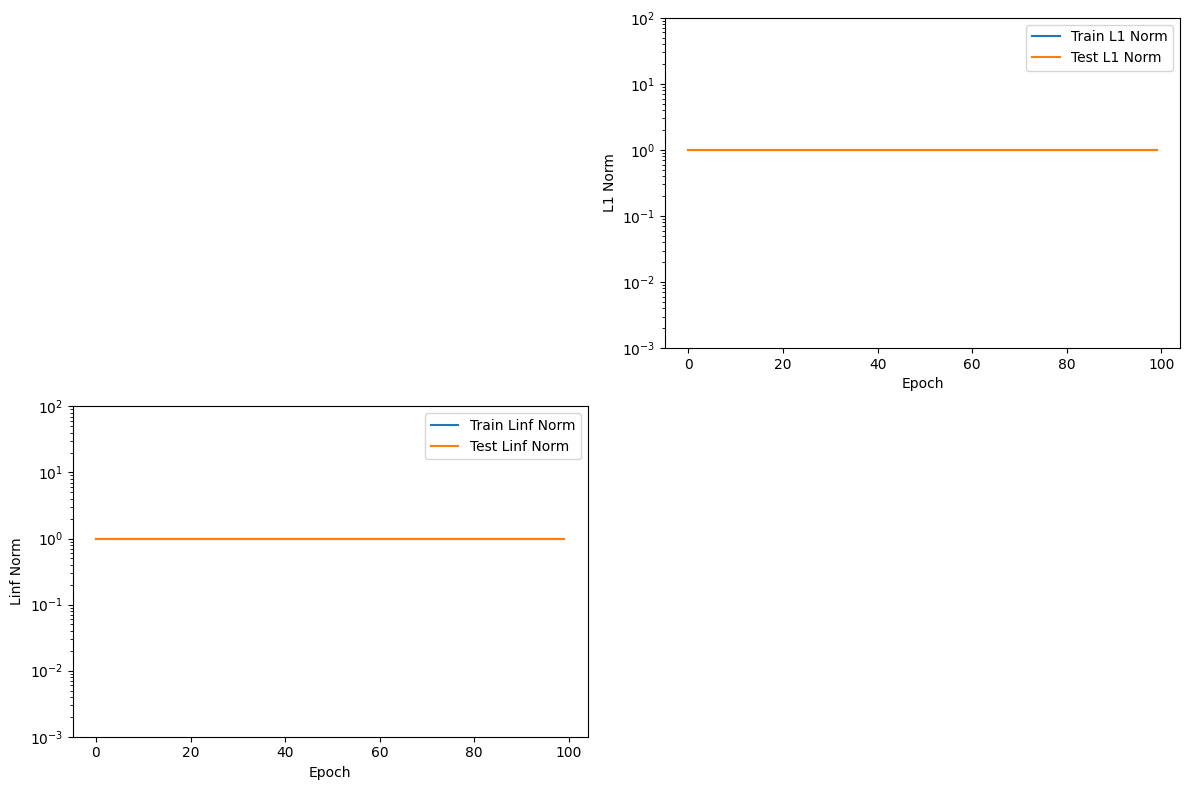

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'MSE')

(1e-07, 1.0)

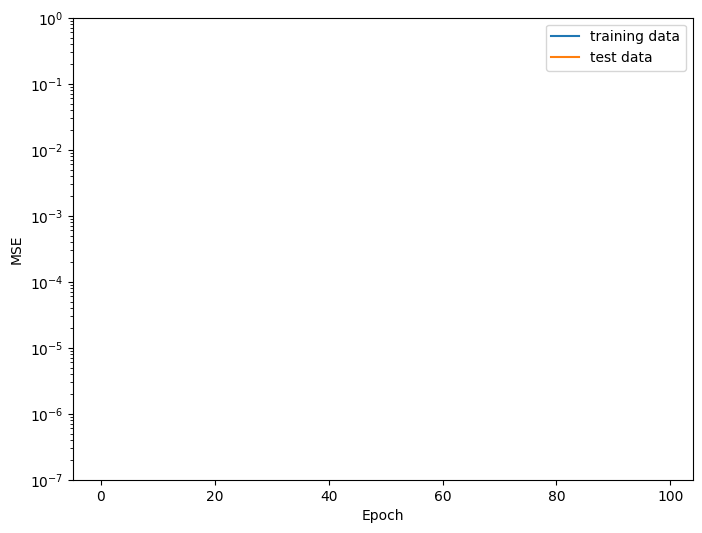

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
net_loaded.load_state_dict(torch.load("net.pth"))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
optimizer_loaded_state_dict = torch.load("optimizer.pth")
if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
scheduler_loaded_state_dict = torch.load("scheduler.pth")
if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

<All keys matched successfully>

In [ ]:
batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
#train_losses_loaded
#test_losses_loaded
#train_metrics_loaded
#test_metrics_loaded

160

100

'Huber'

'Adagrad'

'CosineAnnealingLR'

[851, 951]

2

'ReLU'

'ReLU'

0.0009397168155771956

ReLU()

ReLU()

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=851, bias=True)
    (1): Linear(in_features=851, out_features=951, bias=True)
    (2): Linear(in_features=951, out_features=1, bias=True)
  )
)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('hidden_activation', ReLU()),
              ('output_activation', ReLU()),
              ('layers',
               ModuleList(
                 (0): Linear(in_features=3, out_features=851, bias=True)
                 (1): Linear(in_features=851, out_features=951, bias=True)
                 (2): Linear(in_features=951, out_features=1, bias=True)
               ))]),
 'n_layers': 2,
 'n_units': [851, 951]}

SmoothL1Loss()

Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    initial_lr: 0.0009397168155771956
    lr: 0.00023492920389430117
    lr_decay: 0
    maximize: False
    weight_decay: 0
)

{'defaults': {'lr': 0.0009397168155771956,
  'lr_decay': 0,
  'eps': 1e-10,
  'weight_decay': 0,
  'initial_accumulator_value': 0,
  'foreach': None,
  'maximize': False,
  'differentiable': False},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#Adagrad.zero_grad',
 'state': defaultdict(dict,
             {Parameter containing:
              tensor([[-0.3557,  0.2756, -0.5748],
                      [ 0.1961, -0.0366, -0.2183],
                      [ 0.2115, -0.4546, -0.3314],
                      ...,
                      [ 0.1896,  0.0497,  0.0071],
                      [-0.4417,  0.4081,  0.5174],
                      [-0.2890,  0.3163, -0.4562]], device='cuda:0', requires_grad=True): {'step': tensor(50000.),
               'sum': tensor([[0., 0., 0.],
                       [0., 0., 0.],
                       [0., 0., 0.],
                       ...,
                       [0., 0., 0.

{'T_max': 15,
 'eta_min': 0,
 'optimizer': Adagrad (
 Parameter Group 0
     differentiable: False
     eps: 1e-10
     foreach: None
     initial_accumulator_value: 0
     initial_lr: 0.0009397168155771956
     lr: 0.00023492920389430117
     lr_decay: 0
     maximize: False
     weight_decay: 0
 ),
 'base_lrs': [0.0009397168155771956],
 'last_epoch': 100,
 'verbose': False,
 '_step_count': 101,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.00023492920389430117]}

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"


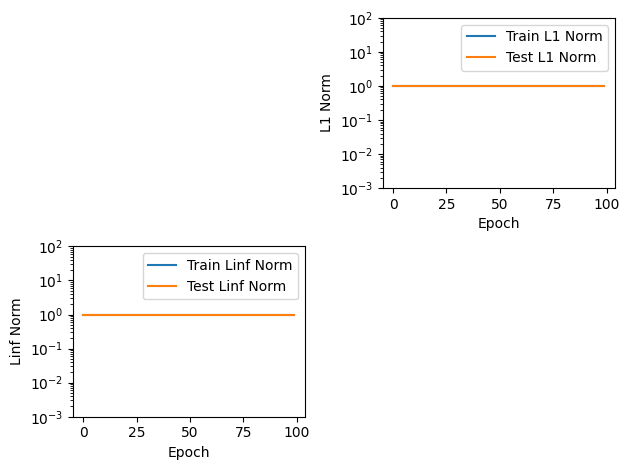

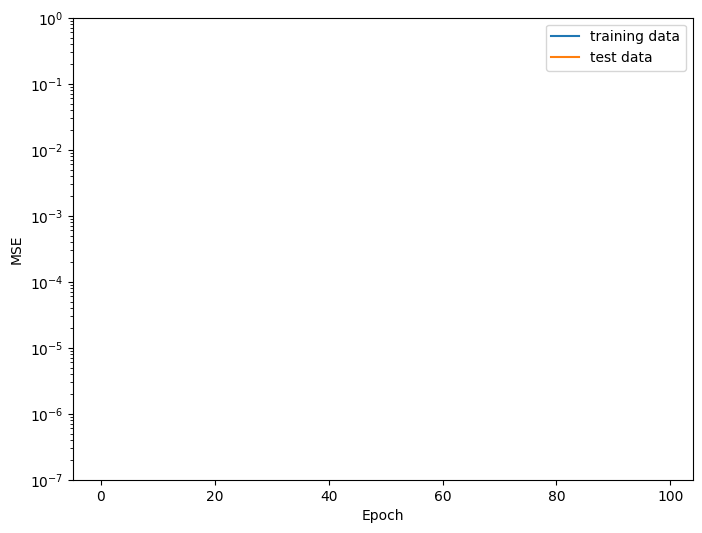

In [ ]:

# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network.

In [ ]:
print(list(net.parameters()))

[Parameter containing:
tensor([[-0.3557,  0.2756, -0.5748],
        [ 0.1961, -0.0366, -0.2183],
        [ 0.2115, -0.4546, -0.3314],
        ...,
        [ 0.1896,  0.0497,  0.0071],
        [-0.4417,  0.4081,  0.5174],
        [-0.2890,  0.3163, -0.4562]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-2.0970e-01,  1.5861e-01, -6.9492e-02, -2.3129e-01, -1.3472e-01,
         4.2665e-01, -1.6973e-01,  4.3699e-01, -3.4039e-01, -4.2071e-01,
        -2.9541e-01, -3.3475e-01, -4.4960e-02, -5.2899e-01,  2.1078e-01,
        -1.5990e-01,  2.5831e-01,  1.7919e-01,  3.2336e-01, -2.6543e-02,
         5.7367e-02,  3.0431e-01, -5.7814e-02,  5.2658e-01, -4.4555e-01,
         2.7170e-01,  4.9085e-01, -5.7607e-01,  1.8293e-01,  4.1617e-01,
        -6.4695e-02,  5.6758e-01, -1.0015e-02, -2.6009e-01, -3.1018e-01,
        -5.0600e-01,  1.9232e-01, -1.8788e-01,  1.1765e-01,  5.3058e-01,
        -3.7663e-01, -2.4296e-01,  2.6921e-02,  2.1530e-01, -2.6870e-01,
        -1.0251e-01, -1.

In [ ]:
print(list(net_loaded.parameters()))

[Parameter containing:
tensor([[-0.3557,  0.2756, -0.5748],
        [ 0.1961, -0.0366, -0.2183],
        [ 0.2115, -0.4546, -0.3314],
        ...,
        [ 0.1896,  0.0497,  0.0071],
        [-0.4417,  0.4081,  0.5174],
        [-0.2890,  0.3163, -0.4562]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-2.0970e-01,  1.5861e-01, -6.9492e-02, -2.3129e-01, -1.3472e-01,
         4.2665e-01, -1.6973e-01,  4.3699e-01, -3.4039e-01, -4.2071e-01,
        -2.9541e-01, -3.3475e-01, -4.4960e-02, -5.2899e-01,  2.1078e-01,
        -1.5990e-01,  2.5831e-01,  1.7919e-01,  3.2336e-01, -2.6543e-02,
         5.7367e-02,  3.0431e-01, -5.7814e-02,  5.2658e-01, -4.4555e-01,
         2.7170e-01,  4.9085e-01, -5.7607e-01,  1.8293e-01,  4.1617e-01,
        -6.4695e-02,  5.6758e-01, -1.0015e-02, -2.6009e-01, -3.1018e-01,
        -5.0600e-01,  1.9232e-01, -1.8788e-01,  1.1765e-01,  5.3058e-01,
        -3.7663e-01, -2.4296e-01,  2.6921e-02,  2.1530e-01, -2.6870e-01,
        -1.0251e-01, -1.

In [ ]:
# Set the network to evaluation mode
net.eval()

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=851, bias=True)
    (1): Linear(in_features=851, out_features=951, bias=True)
    (2): Linear(in_features=951, out_features=1, bias=True)
  )
)

In [ ]:
rho_example, vx_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, epsilon_example)
inputs

tensor([[ 4.9777,  0.7673,  6.2203],
        [ 0.9343,  0.5673,  0.7481],
        [ 9.5240,  4.3588,  2.7322],
        [ 3.8353,  2.0934,  2.4345],
        [ 3.5415,  3.2076,  6.1981],
        [ 9.8912,  2.1926,  2.3524],
        [ 3.5038,  8.2038,  7.4791],
        [ 8.7766,  2.2940,  0.7572],
        [ 2.4173,  8.3406,  8.2503],
        [ 9.0417, 17.3542, 13.3846],
        [10.0062, 14.9280,  9.6037],
        [ 1.9594,  0.0917,  3.8465],
        [ 0.1373,  0.0990,  0.0461],
        [ 2.2944,  0.2890,  1.3364],
        [ 2.0867,  2.7552,  3.2551],
        [ 3.5846,  1.5480,  1.0353],
        [ 9.9863,  9.1802,  6.6595],
        [ 6.2510,  7.0274, 12.5251],
        [ 3.5860,  3.4944,  4.6863],
        [ 5.5023,  5.9426,  4.3249]], device='cuda:0')

In [ ]:
# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

[tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', 

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()


Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=851, bias=True)
    (1): Linear(in_features=851, out_features=951, bias=True)
    (2): Linear(in_features=951, out_features=1, bias=True)
  )
)

In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

[tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.], device='cuda:0', 

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 3) to trace the model
dummy_input = torch.randn(1, 3).to(device)
dummy_input

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)

tensor([[-1.3947,  0.4372, -1.5678]], device='cuda:0')

tensor([[ 9.7484, 11.7281, 11.6981]], device='cuda:0')

tensor([[0.]], device='cuda:0', grad_fn=<ReluBackward0>)